# Microkinetic Modelling of SAKE Datasets

### Import packages

In [1]:
import os
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from scipy.integrate import odeint, solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from __future__ import annotations

import os
from pathlib import Path
from typing import Optional, Tuple, Union

pd.set_option('display.float_format', '{:.9f}'.format)

## Modelling functions for selected model

In [2]:
# ----------------------------
# Model Definition
# ----------------------------
def selected_3parameter_model(y, t, Kk2, Kk3, KI, KI_speed, epsilon=1e-6):
    """
    ODE model describing reaction kinetics with 5 species:
    A, P, B, Phenol, Bd
    
    Parameters:
        y : list
            Current concentrations [A, P, B, Phenol, Bd]
        t : float
            Time (not directly used but required for ODE solvers)
        Kk2, Kk3 : float
            Reaction rate constants
        KI : float
            Some scaling constant
        KI_speed : float
            Transfer rate parameter
        epsilon : float, optional
            Small positive value to prevent division by zero / negatives
    
    Returns:
        dydt : list
            Derivatives [dA/dt, dP/dt, dB/dt, dPhenol/dt, dBd/dt]
    """
    A, P, B, Phenol, Bd = y

    # Enforce positivity (avoid zero/negative concentrations)
    A = max(A, epsilon)
    B = max(B, epsilon)
    Phenol = max(Phenol, epsilon)
    Bd = max(Bd, epsilon)
    
    dA_dt = -Kk2 * A * B - Kk3 * A * B**2
    dP_dt = Kk2 * A * B + Kk3 * A * B**2
    dB_dt = -Kk2 * A * B - Kk3 * A * B**2 + (KI_speed / KI) * Bd - KI_speed * B * Phenol
    dPhenol_dt = Kk2 * A * B + Kk3 * A * B**2 + (KI_speed / KI) * Bd - KI_speed * B * Phenol
    dBd_dt = KI_speed * B * Phenol - (KI_speed / KI) * Bd

    return [dA_dt, dP_dt, dB_dt, dPhenol_dt, dBd_dt]

# ----------------------------
# Simulation Functions
# ----------------------------

def simulate_selected_3parameter_model(t, Kk2, Kk3, KI, KI_speed, initial_conditions):
    """
    Simulate selected_3parameter_model using odeint.
    
    Parameters:
        t : array
            Time points for evaluation
        Kk2, Kk3, KI, KI_speed : float
            Model parameters
        initial_conditions : list
            Initial concentrations [A, P, B, Phenol, Bd]
    
    Returns:
        sol : ndarray
            Solution with shape (len(t), 5)
    """
    sol = odeint(
        selected_3parameter_model, initial_conditions, t, 
        args=(Kk2, Kk3, KI, KI_speed), 
        rtol=1e-9, atol=1e-10
    )
    return sol

# ----------------------------
# Wrapper for Curve Fitting
# ----------------------------
def wrapper_selected_3parameter_model(global_time, Kk2, Kk3, KI, KI_speed, all_times, all_initial_conditions):
    """
    Wrapper for curve fitting. Simulates A and P across multiple datasets,
    interpolates to experimental timepoints, and concatenates results.
    """
    concatenated_results = []

    for time, initial_conditions in zip(all_times, all_initial_conditions):
        t_dense = np.linspace(min(time), max(time), 5000)
        sol = simulate_selected_3parameter_model(t_dense, Kk2, Kk3, KI, KI_speed, initial_conditions)

        # Interpolations
        interp_A = interp1d(t_dense, sol[:, 0], kind='linear', fill_value='extrapolate')
        interp_P = interp1d(t_dense, sol[:, 1], kind='linear', fill_value='extrapolate')

        concatenated_results.extend(interp_A(time))
        concatenated_results.extend(interp_P(time))

    return np.array(concatenated_results)

def wrapper_selected_3parameter_model(global_time, Kk2, Kk3, KI, KI_speed, all_times, all_initial_conditions):
    concatenated_results = []

    for time, initial_conditions in zip(all_times, all_initial_conditions):
        t_dense = np.linspace(min(time), max(time), 5000)

        sol = simulate_selected_3parameter_model(t_dense, Kk2, Kk3, KI, KI_speed, initial_conditions)

        # If solver produced NaN/inf, return a large finite penalty vector
        if not np.isfinite(sol).all():
            # length contribution per dataset = len(time) for A + len(time) for P
            n = 2 * len(time)
            return np.full(sum(2 * len(t) for t in all_times), 1e20, dtype=float)

        interp_A = interp1d(t_dense, sol[:, 0], kind='linear', fill_value='extrapolate')
        interp_P = interp1d(t_dense, sol[:, 1], kind='linear', fill_value='extrapolate')

        A_sim = interp_A(time)
        P_sim = interp_P(time)

        if (not np.isfinite(A_sim).all()) or (not np.isfinite(P_sim).all()):
            return np.full(sum(2 * len(t) for t in all_times), 1e20, dtype=float)

        concatenated_results.extend(A_sim)
        concatenated_results.extend(P_sim)

    return np.array(concatenated_results, dtype=float)

In [3]:
def fit_and_analyse_selected_3parameter_model(
    file: Union[str, os.PathLike],
    KI_speed: float = 1.0,
    plot_B: bool = False,
    plot_Phenol: bool = False,
    figsize_final: Tuple[float, float] = (7, 5),
    subplot_figsize: Tuple[float, float] = (6, 4),
    save_individual_graphs: bool = False,
    figure_folder: Union[str, os.PathLike] = "plots",
    individual_plots_legend: bool = True,
    labels: bool = True,
    subplots: bool = True,
    legend_position: Optional[str] = None,
    convert_to_SI: bool = False,
    save_combined_plot: bool = False,
    combined_plot_name: str = "combined_plot",
    plot_extension: str = ".tiff",
    dpi: int = 300,
) -> pd.DataFrame:
    """
    Fit the selected 3-parameter model across all sheets in an Excel workbook and
    optionally generate/saves plots.

    -------------------------------------------------------------------------
    PARAMETERS
    -------------------------------------------------------------------------
    file : str or path-like
        Path to an .xlsx workbook containing experimental time-course sheets.

    KI_speed : float, default=1.0
        Scaling factor passed into wrapper_selected_3parameter_model / simulate_selected_3parameter_model.

    plot_B : bool, default=False
        If True, include model-predicted B and Bd traces on a secondary y-axis.

    plot_Phenol : bool, default=False
        If True, include model-predicted Phenol trace on a secondary y-axis.

    figsize_final : (float, float), default=(7, 5)
        Figure size for the global concatenated plot.

    subplot_figsize : (float, float), default=(6, 4)
        Figure size for each individual per-sheet plot when saving or displaying subplots.

    save_individual_graphs : bool, default=False
        If True, save each per-sheet plot to:
            <figure_folder>/<sheet_name_sanitized><plot_extension>

    figure_folder : str or path-like, default="plots"
        Folder where saved plots are written. Created if it doesn't exist.

    individual_plots_legend : bool, default=True
        If True, show legends on the individual per-sheet plots (saved and/or displayed).

    labels : bool, default=True
        If True, label axes/titles.

    subplots : bool, default=True
        If True, generate per-sheet subplots in a single figure (display only).
        Note: saving individual plots is controlled by `save_individual_graphs`.

    legend_position : str or None, default=None
        Legend location string passed to matplotlib (e.g., "best", "upper right").
        If None, uses "best".

    convert_to_SI : bool, default=False
        If True, converts fitted parameters after fitting for reporting only:
            Kk2 := Kk2 * 16.66666
            Kk3 := Kk3 * 16.66666 * 1000

    save_combined_plot : bool, default=False
        If True, save the global concatenated plot to:
            <figure_folder>/<combined_plot_name><plot_extension>

    combined_plot_name : str, default="combined_plot"
        Base filename (no extension) for the combined plot.

    plot_extension : str, default=".tiff"
        Extension used for saving plots (e.g. ".tiff", ".png", ".pdf").
        If you pass "tiff" without a leading dot, it will be normalized to ".tiff".

    dpi : int, default=300
        Resolution (dots per inch) used when saving plots.

    -------------------------------------------------------------------------
    RETURNS
    -------------------------------------------------------------------------
    pandas.DataFrame
        One-row table containing:
            - Kk2, Kk3, KI (optionally converted)
            - R2_A, R2_P (global R² across concatenated points)
            - RMSE_A, RMSE_P, RMSE_total
    """

    # ---------- helpers ----------
    def _ensure_folder(folder: Union[str, os.PathLike]) -> Path:
        p = Path(folder)
        p.mkdir(parents=True, exist_ok=True)
        return p

    def _normalize_ext(ext: str) -> str:
        ext = ext.strip()
        if not ext:
            return ".tiff"
        return ext if ext.startswith(".") else f".{ext}"

    def _sanitize_filename(name: str) -> str:
        # Windows-safe-ish: remove forbidden characters and trim.
        bad = '<>:"/\\|?*'
        for ch in bad:
            name = name.replace(ch, "_")
        return name.strip().strip(".") or "plot"

    def _save_figure(fig: plt.Figure, folder: Path, base_name: str) -> Path:
        out = folder / f"{_sanitize_filename(base_name)}{plot_extension}"
        fig.savefig(out, dpi=dpi, bbox_inches="tight")
        return out

    plot_extension = _normalize_ext(plot_extension)
    out_dir = _ensure_folder(figure_folder)

    # ----------------------------
    # Data Preprocessing
    # ----------------------------
    xlsx = pd.ExcelFile(file)
    sheets = xlsx.sheet_names

    all_initial_conditions, all_times, all_times_duplicate = [], [], []
    all_data, number_datapoints = [], []

    for sheet in sheets:
        df = xlsx.parse(sheet)

        time = df.iloc[:, 0].values
        A = df.iloc[:, 1].values
        P = df.iloc[:, 2].values
        B = df.iloc[:, 3].values
        Phenol = df.iloc[:, 4].values

        initial_conditions = [A[0], P[0], B[0], Phenol[0], 0]

        all_times.append(time)
        all_times_duplicate.extend(time)
        all_times_duplicate.extend(time)  # duplicated to align A & P
        all_initial_conditions.append(initial_conditions)

        all_data.append(np.column_stack((A, P)))
        number_datapoints.append(len(time))

    print("Number of datapoints per SAKE period:", number_datapoints)

    # ----------------------------
    # Weights for Curve Fitting
    # ----------------------------
    weights_per_sheet = np.array(number_datapoints) + np.mean(number_datapoints) / 2.5
    weights = []
    for w_sheet, npts in zip(weights_per_sheet, number_datapoints):
        weights += [w_sheet] * npts
        weights += [w_sheet] * npts  # duplicated (A & P both weighted)

    weights_steepness = []
    for time, data in zip(all_times, all_data):
        A_obs, P_obs = data[:, 0], data[:, 1]
        dA_dt = np.abs(np.gradient(A_obs, time))
        dP_dt = np.abs(np.gradient(P_obs, time))
    
        weight_A = 0.35 + 1 / (0.4 + dA_dt / np.max(dA_dt))
        weight_P = 0.35 + 1 / (0.4 + dP_dt / np.max(dP_dt))
    
        weights_steepness.extend(weight_A)
        weights_steepness.extend(weight_P)

    scaler = MinMaxScaler(feature_range=(min(weights_steepness), max(weights_steepness)))
    weights_scaled = scaler.fit_transform(np.array(weights).reshape(-1, 1)).flatten()
    final_sigma_weights = weights_steepness + weights_scaled

    # ----------------------------
    # Curve Fitting
    # ----------------------------
    combined_exp_AP = []
    for data in all_data:
        combined_exp_AP.extend(data[:, 0])  # A
        combined_exp_AP.extend(data[:, 1])  # P

    initial_guess = [0.0001, 0.0002, 0.001]
    bounds = ([1e-11, 1e-11, 0.000001], [50, 50, 0.5])

    best_params, _ = curve_fit(
        lambda t, Kk2, Kk3, KI: wrapper_selected_3parameter_model(
            t, Kk2, Kk3, KI, KI_speed, all_times, all_initial_conditions
        ),
        all_times_duplicate,
        combined_exp_AP,
        p0=initial_guess,
        bounds=bounds,
        sigma=final_sigma_weights,
        absolute_sigma=False,
    )
    # ----------------------------
    # Plotting & Metrics
    # ----------------------------
    # Subplots display figure (one figure with many axes)
    if subplots:
        plt.figure(figsize=(subplot_figsize[0], subplot_figsize[1] * len(all_times)))

    times, combined_exp_A, combined_sim_A = [], [], []
    combined_exp_P, combined_sim_P = [], []
    if plot_B:
        combined_sim_B, combined_sim_Bd = [], []
    if plot_Phenol:
        combined_sim_Phenol = []

    for i, (time, data, initial_conditions) in enumerate(
        zip(all_times, all_data, all_initial_conditions)
    ):
        t_dense = np.linspace(min(time), max(time), 10000)
        sol = simulate_selected_3parameter_model(t_dense, *best_params, KI_speed, initial_conditions)

        interp_A = interp1d(t_dense, sol[:, 0], kind="linear", fill_value="extrapolate")
        interp_P = interp1d(t_dense, sol[:, 1], kind="linear", fill_value="extrapolate")
        A_interp, P_interp = interp_A(time), interp_P(time)

        combined_exp_A.extend(data[:, 0])
        combined_sim_A.extend(A_interp)
        combined_exp_P.extend(data[:, 1])
        combined_sim_P.extend(P_interp)
        times.extend(time)

        if plot_B:
            interp_B = interp1d(t_dense, sol[:, 2], kind="linear", fill_value="extrapolate")
            interp_Bd = interp1d(t_dense, sol[:, 4], kind="linear", fill_value="extrapolate")
            combined_sim_B.extend(interp_B(time))
            combined_sim_Bd.extend(interp_Bd(time))

        if plot_Phenol:
            interp_Phenol = interp1d(t_dense, sol[:, 3], kind="linear", fill_value="extrapolate")
            combined_sim_Phenol.extend(interp_Phenol(time))

        # ---------- per-sheet plot saving ----------
        if save_individual_graphs:
            fig_i, ax_i = plt.subplots(figsize=subplot_figsize)

            ax_i.plot(time, data[:, 0], "o", label="A (data)", markersize=2)
            ax_i.plot(t_dense, sol[:, 0], "-", label="A (fit)")
            ax_i.plot(time, data[:, 1], "o", label="P (data)", markersize=2)
            ax_i.plot(t_dense, sol[:, 1], "-", label="P (fit)")

            if labels:
                ax_i.set_title(f"Fit for {sheets[i]}")
                ax_i.set_xlabel("Time / min")
                ax_i.set_ylabel("Concentration / mM")

            if plot_B or plot_Phenol:
                ax2_i = ax_i.twinx()
                if plot_B:
                    ax2_i.plot(t_dense, sol[:, 2], "-", label="B (fit)", color="tab:green")
                    ax2_i.plot(t_dense, sol[:, 4], "-", label="Bd (fit)", color="tab:olive")
                if plot_Phenol:
                    ax2_i.plot(t_dense, sol[:, 3], "-", label="Phenol (fit)", color="tab:red")
                if labels:
                    ax2_i.set_ylabel("Conc. B/Bd/Phenol (mM)")

                if individual_plots_legend:
                    lines1, labels1 = ax_i.get_legend_handles_labels()
                    lines2, labels2 = ax2_i.get_legend_handles_labels()
                    ax_i.legend(lines1 + lines2, labels1 + labels2, loc=(legend_position or "best"))
            else:
                if individual_plots_legend:
                    ax_i.legend(loc=(legend_position or "best"))

            fig_i.tight_layout()
            saved_path = _save_figure(fig_i, out_dir, base_name=sheets[i])
            plt.close(fig_i)  # important for batch runs
            print("Saved individual plot:", saved_path)

        # ---------- display subplot in the big figure ----------
        if subplots:
            ax1 = plt.subplot(len(all_times), 1, i + 1)
            ax1.plot(time, data[:, 0], "o", label="A (data)", markersize=2)
            ax1.plot(t_dense, sol[:, 0], "-", label="A (fit)")
            ax1.plot(time, data[:, 1], "o", label="P (data)", markersize=2)
            ax1.plot(t_dense, sol[:, 1], "-", label="P (fit)")

            if labels:
                ax1.set_title(f"Fit for {sheets[i]}")
                ax1.set_xlabel("Time / min")
                ax1.set_ylabel("Concentration / mM")

            if plot_B or plot_Phenol:
                ax2 = ax1.twinx()
                if plot_B:
                    ax2.plot(t_dense, sol[:, 2], "-", label="B (fit)", color="tab:green")
                    ax2.plot(t_dense, sol[:, 4], "-", label="Bd (fit)", color="tab:olive")
                if plot_Phenol:
                    ax2.plot(t_dense, sol[:, 3], "-", label="Phenol (fit)", color="tab:red")
                if labels:
                    ax2.set_ylabel("Conc. B/Bd/Phenol (mM)")

                lines1, labels1 = ax1.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                if individual_plots_legend:
                    ax1.legend(lines1 + lines2, labels1 + labels2, loc=(legend_position or "best"))
            else:
                if individual_plots_legend:
                    ax1.legend(loc=(legend_position or "best"))

    if subplots:
        plt.tight_layout()
        plt.show()

    # ----------------------------
    # Global combined plot
    # ----------------------------
    global_times, cumulative_time = [], 0
    for i, t in enumerate(times):
        if i > 0 and t < times[i - 1]:
            cumulative_time += times[i - 1]
        global_times.append(t + cumulative_time)

    fig, ax1 = plt.subplots(figsize=figsize_final)
    ax1.plot(global_times, combined_exp_A, "o", markersize=1.2, label="Data A")
    ax1.plot(global_times, combined_sim_A, "-", label="Model A")
    ax1.plot(global_times, combined_exp_P, "o", markersize=1.2, label="Data P")
    ax1.plot(global_times, combined_sim_P, "-", label="Model P")

    if labels:
        ax1.set_xlabel("Time / min")
        ax1.set_ylabel("Concentration / mM")

    ax1.set_ylim(0, None)
    ax1.legend(loc=(legend_position or "best"))

    if plot_B or plot_Phenol:
        ax2 = ax1.twinx()
        if plot_B:
            ax2.plot(global_times, combined_sim_B, "-", label="Model B", color="tab:green")
            ax2.plot(global_times, combined_sim_Bd, "-", label="Model Bd", color="tab:olive")
        if plot_Phenol:
            ax2.plot(global_times, combined_sim_Phenol, "-", label="Model Phenol", color="tab:red")
        if labels:
            ax2.set_ylabel("B, Bd, Phenol (mM)")

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc=(legend_position or "best"))

    plt.xlim(0, None)

    if save_combined_plot:
        saved_path = _save_figure(fig, out_dir, base_name=combined_plot_name)
        print("Combined best-fit graph saved as:", saved_path)

    plt.show()

    # ----------------------------
    # Statistics & Output
    # ----------------------------
    r2_global_A = r2_score(combined_exp_A, combined_sim_A)
    r2_global_P = r2_score(combined_exp_P, combined_sim_P)
    rmse_global_A = np.sqrt(np.mean((np.array(combined_exp_A) - np.array(combined_sim_A)) ** 2))
    rmse_global_P = np.sqrt(np.mean((np.array(combined_exp_P) - np.array(combined_sim_P)) ** 2))

    best_params = np.array(best_params, dtype=float)
    if convert_to_SI:
        best_params[0] = best_params[0] * 16.66666
        best_params[1] = best_params[1] * 16.66666 * 1000

    results = {
        "Kk2": [best_params[0]],
        "Kk3": [best_params[1]],
        "KI": [best_params[2]],
        "R2_A": [r2_global_A],
        "R2_P": [r2_global_P],
        "RMSE_A": [rmse_global_A],
        "RMSE_P": [rmse_global_P],
        "RMSE_total": [(rmse_global_P + rmse_global_A) / 2],
    }
    return pd.DataFrame(results)


In [4]:
# ----------------------------------------------------------------------
# Model definition
# ----------------------------------------------------------------------
def selected_3parameter_model_piperazine(y, t, Kk2, Kk3, KI, KI_speed, epsilon=1e-6):
    """
    ODE model for selected_3parameter_model piperazine system with safety checks to avoid
    negative concentrations.
    """
    A, P, B, Phenol, Bd = [max(v, epsilon) for v in y]

    dA_dt = -Kk2 * A * (2 * B) - Kk3 * A * (2 * B) ** 2
    dP_dt = Kk2 * A * (2 * B) + Kk3 * A * (2 * B) ** 2
    dB_dt = -Kk2 * A * (2 * B) - Kk3 * A * (2 * B) ** 2 \
            + KI_speed / KI * Bd - KI_speed * (2 * B) * Phenol
    dPhenol_dt = Kk2 * A * (2 * B) + Kk3 * A * (2 * B) ** 2 \
                 + KI_speed / KI * Bd - KI_speed * (2 * B) * Phenol
    dBd_dt = KI_speed * (2 * B) * Phenol - KI_speed / KI * Bd

    return [dA_dt, dP_dt, dB_dt, dPhenol_dt, dBd_dt]


def simulate_selected_3parameter_model_piperazine(t, Kk2, Kk3, KI, KI_speed, initial_conditions):
    """
    Simulate the ODE model using scipy's odeint.
    """
    sol = odeint(
        selected_3parameter_model_piperazine, initial_conditions, t,
        args=(Kk2, Kk3, KI, KI_speed),
        rtol=1e-8, atol=1e-8
    )
    return sol

# ----------------------------------------------------------------------
# Curve fitting wrapper
# ----------------------------------------------------------------------
def wrapper_selected_3parameter_model_piperazine(global_time, Kk2, Kk3, KI, KI_speed,
                                all_times, all_initial_conditions):
    """
    Wrapper for curve fitting: simulates each SAKE period, interpolates
    A and P to experimental time points, and concatenates results.
    """
    concatenated_results = []
    for time, initial_conditions in zip(all_times, all_initial_conditions):
        t_dense = np.linspace(time.min(), time.max(), 5000)
        sol = simulate_selected_3parameter_model_piperazine(t_dense, Kk2, Kk3, KI, KI_speed, initial_conditions)

        # Interpolations
        interp_A = interp1d(t_dense, sol[:, 0], kind='linear', fill_value='extrapolate')
        interp_P = interp1d(t_dense, sol[:, 1], kind='linear', fill_value='extrapolate')

        concatenated_results.extend(interp_A(time))
        concatenated_results.extend(interp_P(time))

    return np.array(concatenated_results)

In [5]:
def fit_and_analyse_selected_3parameter_model_piperazine(
    file: Union[str, os.PathLike],
    KI_speed: float = 1.0,
    plot_B: bool = False,
    plot_Phenol: bool = False,
    figsize_final: Tuple[float, float] = (7, 5),
    subplot_figsize: Tuple[float, float] = (6, 4),
    save_individual_graphs: bool = False,
    figure_folder: Union[str, os.PathLike] = "plots",
    individual_plots_legend: bool = True,
    labels: bool = True,
    subplots: bool = True,
    legend_position: Optional[str] = None,
    convert_to_SI: bool = False,
    save_combined_plot: bool = False,
    combined_plot_name: str = "combined_plot",
    plot_extension: str = ".tiff",
    dpi: int = 500,
) -> pd.DataFrame:
    """
    Fit the selected_3parameter_model_piperazine kinetic model to an experimental Excel dataset
    and optionally generate/save plots.

    This version implements consistent save behavior:
      - All saved figures go into `figure_folder` (created if missing).
      - Saved filenames are `<plot_name><plot_extension>`, defaulting to `.tiff`.

    -------------------------------------------------------------------------
    PARAMETERS
    -------------------------------------------------------------------------
    file : str or path-like
        Path to an .xlsx workbook containing experimental time-course sheets.

    KI_speed : float, default=1.0
        Scaling factor passed into wrapper_selected_3parameter_model_piperazine /
        simulate_selected_3parameter_model_piperazine.

    plot_B : bool, default=False
        If True, include model-predicted B and Bd traces on a secondary y-axis.

    plot_Phenol : bool, default=False
        If True, include model-predicted Phenol trace on a secondary y-axis.

    figsize_final : (float, float), default=(7, 5)
        Figure size for the global concatenated plot.

    subplot_figsize : (float, float), default=(6, 4)
        Figure size for each individual per-sheet plot (saved) and for the
        multi-subplot display layout sizing.

    save_individual_graphs : bool, default=False
        If True, save each per-sheet plot to:
            <figure_folder>/<sheet_name_sanitized><plot_extension>

    figure_folder : str or path-like, default="plots"
        Folder where saved plots are written. Created if it doesn't exist.

    individual_plots_legend : bool, default=True
        If True, show legends on the individual per-sheet plots (saved and/or displayed).

    labels : bool, default=True
        If True, label axes/titles.

    subplots : bool, default=True
        If True, display per-sheet subplots in a single figure (display only).
        Note: saving individual plots is controlled by `save_individual_graphs`.

    legend_position : str or None, default=None
        Legend location string passed to matplotlib (e.g., "best", "upper right").
        If None, uses "best".

    convert_to_SI : bool, default=False
        If True, converts fitted parameters after fitting for reporting only:
            Kk2 := Kk2 * 16.66666
            Kk3 := Kk3 * 16.66666 * 1000

    save_combined_plot : bool, default=False
        If True, save the global concatenated plot to:
            <figure_folder>/<combined_plot_name><plot_extension>

    combined_plot_name : str, default="combined_plot"
        Base filename (no extension) for the combined plot.

    plot_extension : str, default=".tiff"
        Extension used for saving plots (e.g. ".tiff", ".png", ".pdf").
        If you pass "tiff" without a leading dot, it will be normalized to ".tiff".

    dpi : int, default=500
        Resolution (dots per inch) used when saving plots.

    -------------------------------------------------------------------------
    RETURNS
    -------------------------------------------------------------------------
    pandas.DataFrame
        One-row table containing:
            - Kk2, Kk3, KI (optionally converted)
            - R2_A, R2_P
            - RMSE_A, RMSE_P, RMSE_total
    """

    # ---------- helpers ----------
    def _ensure_folder(folder: Union[str, os.PathLike]) -> Path:
        p = Path(folder)
        p.mkdir(parents=True, exist_ok=True)
        return p

    def _normalize_ext(ext: str) -> str:
        ext = ext.strip()
        if not ext:
            return ".tiff"
        return ext if ext.startswith(".") else f".{ext}"

    def _sanitize_filename(name: str) -> str:
        # Windows-safe-ish: remove forbidden characters and trim.
        bad = '<>:"/\\|?*'
        for ch in bad:
            name = name.replace(ch, "_")
        return name.strip().strip(".") or "plot"

    def _save_figure(fig: plt.Figure, folder: Path, base_name: str) -> Path:
        out = folder / f"{_sanitize_filename(base_name)}{plot_extension}"
        fig.savefig(out, dpi=dpi, bbox_inches="tight")
        return out

    plot_extension = _normalize_ext(plot_extension)
    out_dir = _ensure_folder(figure_folder)

    # ----------------------------
    # Data Preprocessing
    # ----------------------------
    xlsx = pd.ExcelFile(file)
    sheets = xlsx.sheet_names

    all_initial_conditions, all_times, all_times_duplicate = [], [], []
    all_data, number_datapoints = [], []

    for sheet in sheets:
        df = xlsx.parse(sheet)

        time = df.iloc[:, 0].values
        A, P, B, Phenol = df.iloc[:, 1:5].values.T

        initial_conditions = [A[0], P[0], B[0], Phenol[0], 0]

        all_times.append(time)
        all_times_duplicate.extend(time)
        all_times_duplicate.extend(time)  # duplicated to align A & P in curve_fit
        all_initial_conditions.append(initial_conditions)

        all_data.append(np.column_stack((A, P)))
        number_datapoints.append(len(time))

    # ----------------------------
    # Weights calculation
    # ----------------------------
    weights_per_sheet = np.array(number_datapoints) + np.mean(number_datapoints) / 2.5
    weights = []
    for w, n in zip(weights_per_sheet, number_datapoints):
        weights.extend([w] * n)
        weights.extend([w] * n)  # duplicated for A & P

    weights_steepness = []
    for time, data in zip(all_times, all_data):
        A_obs, P_obs = data[:, 0], data[:, 1]
        dA_dt = np.abs(np.gradient(A_obs, time))
        dP_dt = np.abs(np.gradient(P_obs, time))
    
        weight_A = 0.35 + 1 / (0.4 + dA_dt / np.max(dA_dt))
        weight_P = 0.35 + 1 / (0.4 + dP_dt / np.max(dP_dt))
    
        weights_steepness.extend(weight_A)
        weights_steepness.extend(weight_P)

    scaler = MinMaxScaler(feature_range=(min(weights_steepness), max(weights_steepness)))
    weights_scaled = scaler.fit_transform(np.array(weights).reshape(-1, 1)).flatten()
    final_sigma_weights = weights_steepness + weights_scaled

    # ----------------------------
    # Fit model
    # ----------------------------
    combined_exp_AP = []
    for data in all_data:
        combined_exp_AP.extend(data[:, 0])
        combined_exp_AP.extend(data[:, 1])

    initial_guess = [1e-4, 2e-4, 1e-3]
    bounds = ([1e-11, 1e-11, 1e-6], [1, 1, 1])

    best_params, _ = curve_fit(
        lambda t, Kk2, Kk3, KI: wrapper_selected_3parameter_model_piperazine(
            t, Kk2, Kk3, KI, KI_speed, all_times, all_initial_conditions
        ),
        all_times_duplicate,
        combined_exp_AP,
        p0=initial_guess,
        bounds=bounds,
        sigma=final_sigma_weights,
        absolute_sigma=False,
    )

    # ----------------------------
    # Simulate + plotting per sheet
    # ----------------------------
    if subplots:
        plt.figure(figsize=(subplot_figsize[0], subplot_figsize[1] * len(all_times)))

    times = []
    combined_exp_A, combined_sim_A = [], []
    combined_exp_P, combined_sim_P = [], []
    if plot_B:
        combined_sim_B, combined_sim_Bd = [], []
    if plot_Phenol:
        combined_sim_Phenol = []

    for i, (time, data, initial_conditions) in enumerate(
        zip(all_times, all_data, all_initial_conditions)
    ):
        t_dense = np.linspace(time.min(), time.max(), 10000)
        sol = simulate_selected_3parameter_model_piperazine(
            t_dense, *best_params, KI_speed, initial_conditions
        )

        # Interpolate A, P
        A_interp = interp1d(t_dense, sol[:, 0], kind="linear", fill_value="extrapolate")(time)
        P_interp = interp1d(t_dense, sol[:, 1], kind="linear", fill_value="extrapolate")(time)

        combined_exp_A.extend(data[:, 0])
        combined_sim_A.extend(A_interp)
        combined_exp_P.extend(data[:, 1])
        combined_sim_P.extend(P_interp)
        times.extend(time)

        # Optional interpolations for B/Bd/Phenol
        if plot_B:
            B_interp = interp1d(t_dense, sol[:, 2], kind="linear", fill_value="extrapolate")(time)
            Bd_interp = interp1d(t_dense, sol[:, 4], kind="linear", fill_value="extrapolate")(time)
            combined_sim_B.extend(B_interp)
            combined_sim_Bd.extend(Bd_interp)
        if plot_Phenol:
            Phenol_interp = interp1d(t_dense, sol[:, 3], kind="linear", fill_value="extrapolate")(time)
            combined_sim_Phenol.extend(Phenol_interp)

        # ---------- save one plot per sheet ----------
        if save_individual_graphs:
            fig_i, ax1_i = plt.subplots(figsize=subplot_figsize)

            ax1_i.plot(time, data[:, 0], "o", label="A (data)", markersize=2)
            ax1_i.plot(t_dense, sol[:, 0], "-", label="A (fit)")
            ax1_i.plot(time, data[:, 1], "o", label="P (data)", markersize=2)
            ax1_i.plot(t_dense, sol[:, 1], "-", label="P (fit)")

            if labels:
                ax1_i.set_title(f"Fit for {sheets[i]}")
                ax1_i.set_xlabel("Time / min")
                ax1_i.set_ylabel("Concentration / mM")

            if plot_B or plot_Phenol:
                ax2_i = ax1_i.twinx()
                if plot_B:
                    ax2_i.plot(t_dense, sol[:, 2], "-", label="B (fit)", color="tab:green")
                    ax2_i.plot(t_dense, sol[:, 4], "-", label="Bd (fit)", color="tab:olive")
                if plot_Phenol:
                    ax2_i.plot(t_dense, sol[:, 3], "-", label="Phenol (fit)", color="tab:red")
                if labels:
                    ax2_i.set_ylabel("Conc. B/Bd/Phenol (mM)")

                if individual_plots_legend:
                    lines1, labels1 = ax1_i.get_legend_handles_labels()
                    lines2, labels2 = ax2_i.get_legend_handles_labels()
                    ax1_i.legend(lines1 + lines2, labels1 + labels2, loc=(legend_position or "best"))
            else:
                if individual_plots_legend:
                    ax1_i.legend(loc=(legend_position or "best"))

            fig_i.tight_layout()
            saved_path = _save_figure(fig_i, out_dir, base_name=sheets[i])
            plt.close(fig_i)
            print("Saved individual plot:", saved_path)

        # ---------- display subplots in one figure ----------
        if subplots:
            ax1 = plt.subplot(len(all_times), 1, i + 1)
            ax1.plot(time, data[:, 0], "o", label="A (data)", markersize=2)
            ax1.plot(t_dense, sol[:, 0], "-", label="A (fit)")
            ax1.plot(time, data[:, 1], "o", label="P (data)", markersize=2)
            ax1.plot(t_dense, sol[:, 1], "-", label="P (fit)")

            if labels:
                ax1.set_title(f"Fit for {sheets[i]}")
                ax1.set_xlabel("Time / min")
                ax1.set_ylabel("Concentration / mM")

            if plot_B or plot_Phenol:
                ax2 = ax1.twinx()
                if plot_B:
                    ax2.plot(t_dense, sol[:, 2], "-", label="B (fit)", color="tab:green")
                    ax2.plot(t_dense, sol[:, 4], "-", label="Bd (fit)", color="tab:olive")
                if plot_Phenol:
                    ax2.plot(t_dense, sol[:, 3], "-", label="Phenol (fit)", color="tab:red")
                if labels:
                    ax2.set_ylabel("Conc. B/Bd/Phenol (mM)")

                if individual_plots_legend:
                    lines1, labels1 = ax1.get_legend_handles_labels()
                    lines2, labels2 = ax2.get_legend_handles_labels()
                    ax1.legend(lines1 + lines2, labels1 + labels2, loc=(legend_position or "best"))
            else:
                if individual_plots_legend:
                    ax1.legend(loc=(legend_position or "best"))

    if subplots:
        plt.tight_layout()
        plt.show()

    # ----------------------------
    # Global performance metrics (A & P)
    # ----------------------------
    r2_global_A = r2_score(combined_exp_A, combined_sim_A)
    r2_global_P = r2_score(combined_exp_P, combined_sim_P)
    rmse_global_A = np.sqrt(np.mean((np.array(combined_exp_A) - np.array(combined_sim_A)) ** 2))
    rmse_global_P = np.sqrt(np.mean((np.array(combined_exp_P) - np.array(combined_sim_P)) ** 2))

    # ----------------------------
    # Global combined plot (cumulative time)
    # ----------------------------
    global_times = []
    cumulative_time = 0.0
    for idx, t_val in enumerate(times):
        if idx > 0 and t_val < times[idx - 1]:
            cumulative_time += times[idx - 1]
        global_times.append(t_val + cumulative_time)

    fig, ax1 = plt.subplots(figsize=figsize_final)
    ax1.plot(global_times, combined_exp_A, "o", markersize=1.2, label="Data A")
    ax1.plot(global_times, combined_sim_A, "-", label="Model A")
    ax1.plot(global_times, combined_exp_P, "o", markersize=1.2, label="Data P")
    ax1.plot(global_times, combined_sim_P, "-", label="Model P")

    if labels:
        ax1.set_xlabel("Time / min")
        ax1.set_ylabel("Concentration / mM")
    ax1.set_ylim(0, None)

    if plot_B or plot_Phenol:
        ax2 = ax1.twinx()
        if plot_B:
            ax2.plot(global_times, combined_sim_B, "-", label="Model B", color="tab:green")
            ax2.plot(global_times, combined_sim_Bd, "-", label="Model Bd", color="tab:olive")
        if plot_Phenol:
            ax2.plot(global_times, combined_sim_Phenol, "-", label="Model Phenol", color="tab:red")
        if labels:
            ax2.set_ylabel("B, Bd, Phenol (mM)")

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc=(legend_position or "best"))
    else:
        ax1.legend(loc=(legend_position or "best"))

    plt.xlim(0, None)

    if save_combined_plot:
        saved_path = _save_figure(fig, out_dir, base_name=combined_plot_name)
        print("Combined best-fit graph saved as:", saved_path)

    plt.show()

    # ----------------------------
    # Unit conversion (optional)
    # ----------------------------
    Kk2_out, Kk3_out, KI_out = map(float, best_params)
    if convert_to_SI:
        Kk2_out *= 16.66666
        Kk3_out *= 16.66666 * 1000

    # ----------------------------
    # Return results
    # ----------------------------
    return pd.DataFrame(
        {
            "Kk2": [Kk2_out],
            "Kk3": [Kk3_out],
            "KI": [KI_out],
            "R2_A": [r2_global_A],
            "R2_P": [r2_global_P],
            "RMSE_A": [rmse_global_A],
            "RMSE_P": [rmse_global_P],
            "RMSE_total": [(rmse_global_P + rmse_global_A) / 2],
        }
    )

### Names of datasets

In [6]:
Experiment_names=['C1_E1', 'C1_E2', 'C1_E3', 'C1_E4a','C1_E4b', 'C1_E5', 'C1_E6', 'C1_E7', 'C2_E1', 'C2_E2',
                  'C2_E3', 'C2_E4', 'C2_E5', 'C2_E6',  'C2_E7a', 'C2_E7b', 
                  'C3_E1', 'C3_E2', 'C3_E3', 'C3_E4', 'C3_E5',
                 'C4_E1a', 'C4_E1b', 'C4_E2', 'C4_E3', 'C4_E4', 'C4_E5', 'C4_E6', 'C4_E7', 'C4_E8', 'C4_E9','C4_E10', 'C4_E11']

In [7]:
path_cwd=os.getcwd()
path_datasets=path_cwd.replace('SAKE dataset analysis\\Microkinetic Modelling','SAKE datasets\\')

### Campaign 1: Eyring study for 1a and 2a

In [8]:
Experiment_names_C1=[i for i in Experiment_names if i[1]=='1']
Experiment_paths_C1=[path_datasets+i+'.xlsx' for i in Experiment_names_C1]

Dataset being analysed: C1_E1.xlsx
Number of datapoints per SAKE period: [749, 108, 135, 1371]


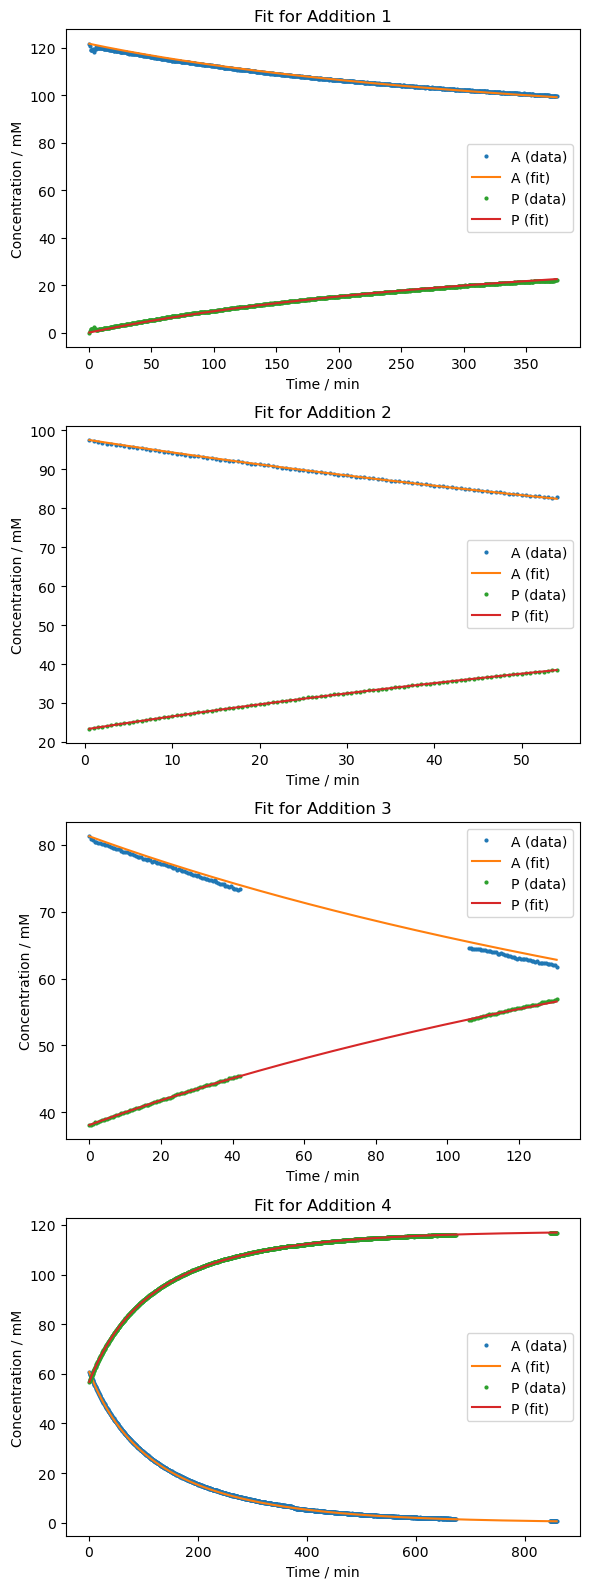

Combined best-fit graph saved as: Results_C1\plots\C1_E1.tiff


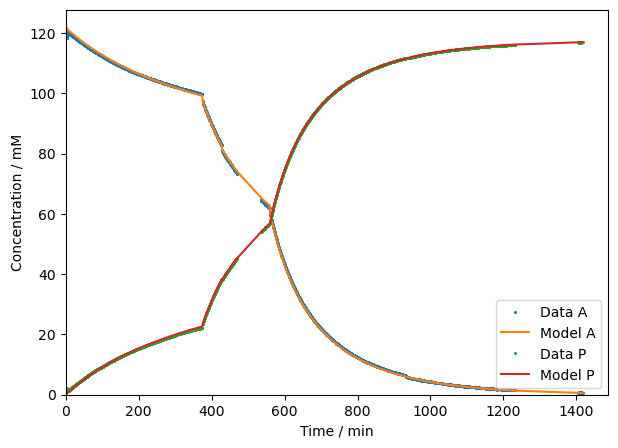

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C1_E1 0.000182932 0.003604876 0.000528680 0.999936868 0.999978662   

       RMSE_A      RMSE_P  RMSE_total  
0 0.362466960 0.202747826 0.282607393

Dataset being analysed: C1_E2.xlsx
Number of datapoints per SAKE period: [617, 250, 1155, 396]


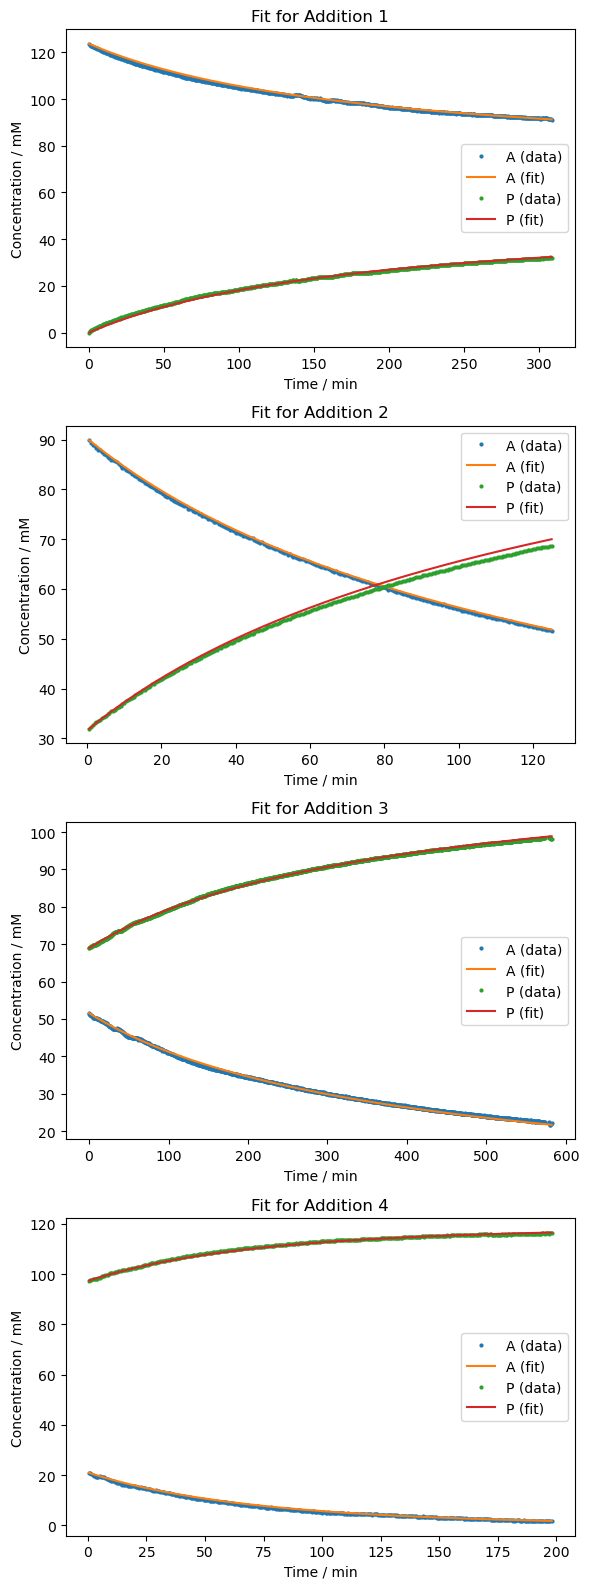

Combined best-fit graph saved as: Results_C1\plots\C1_E2.tiff


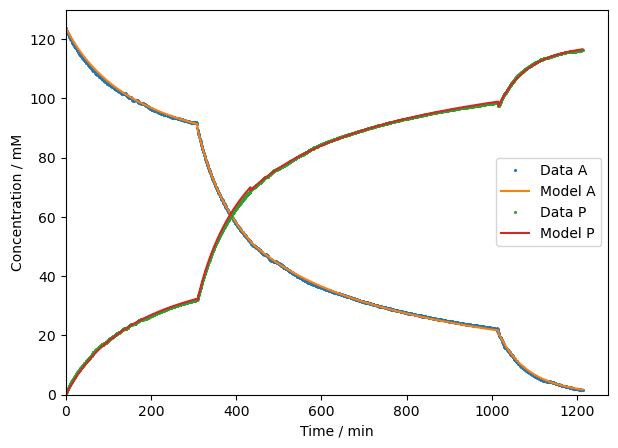

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C1_E2 0.000568539 0.006754421 0.000804323 0.999855902 0.999855291   

       RMSE_A      RMSE_P  RMSE_total  
0 0.420841015 0.403107765 0.411974390

Dataset being analysed: C1_E3.xlsx
Number of datapoints per SAKE period: [294, 56, 139, 677]


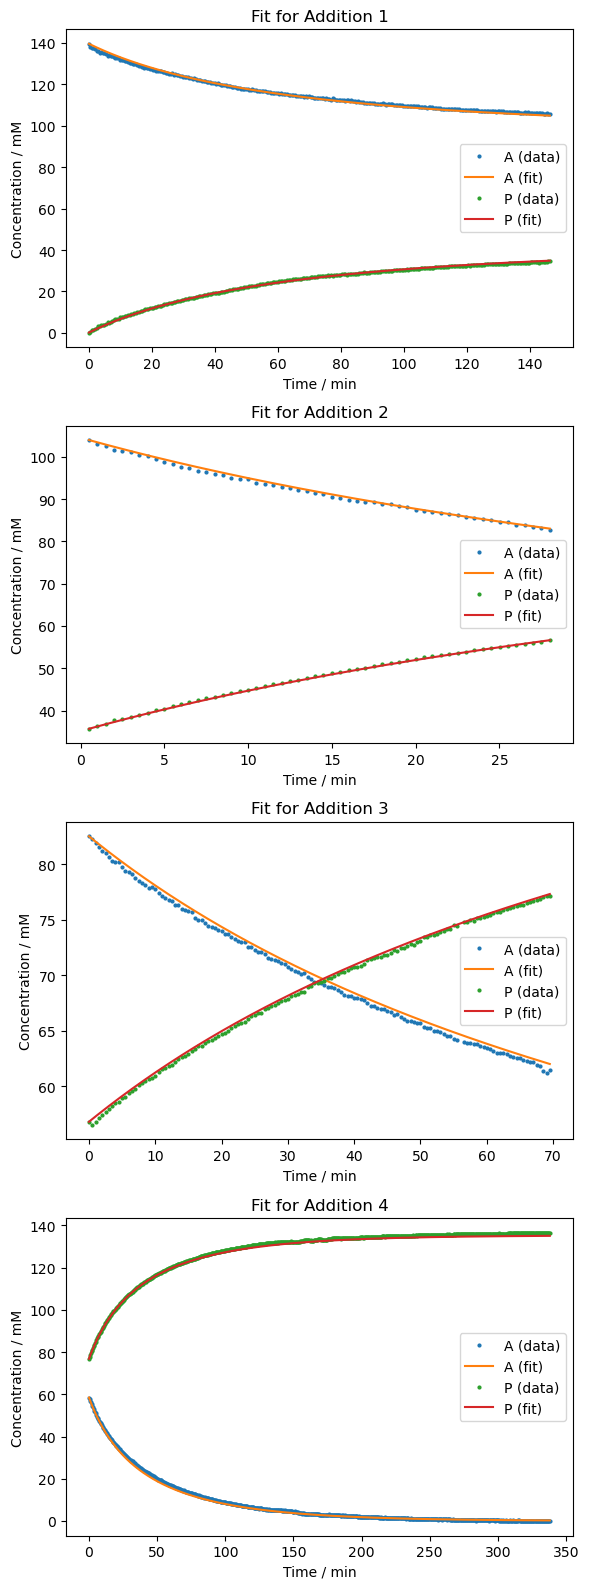

Combined best-fit graph saved as: Results_C1\plots\C1_E3.tiff


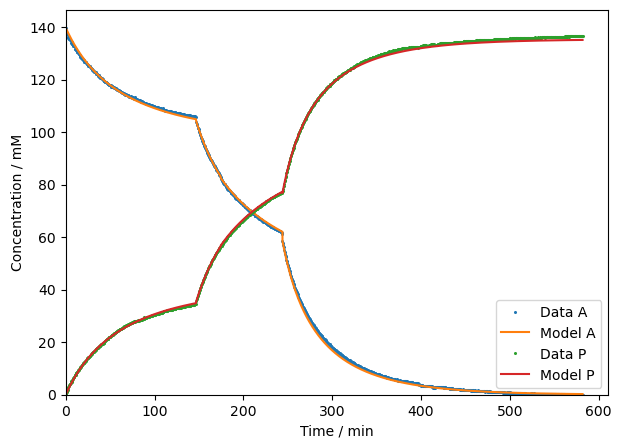

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C1_E3 0.001613349 0.013888609 0.000590360 0.999836932 0.999764950   

       RMSE_A      RMSE_P  RMSE_total  
0 0.615387386 0.716239631 0.665813508

Dataset being analysed: C1_E4a.xlsx
Number of datapoints per SAKE period: [262, 62, 109, 173]


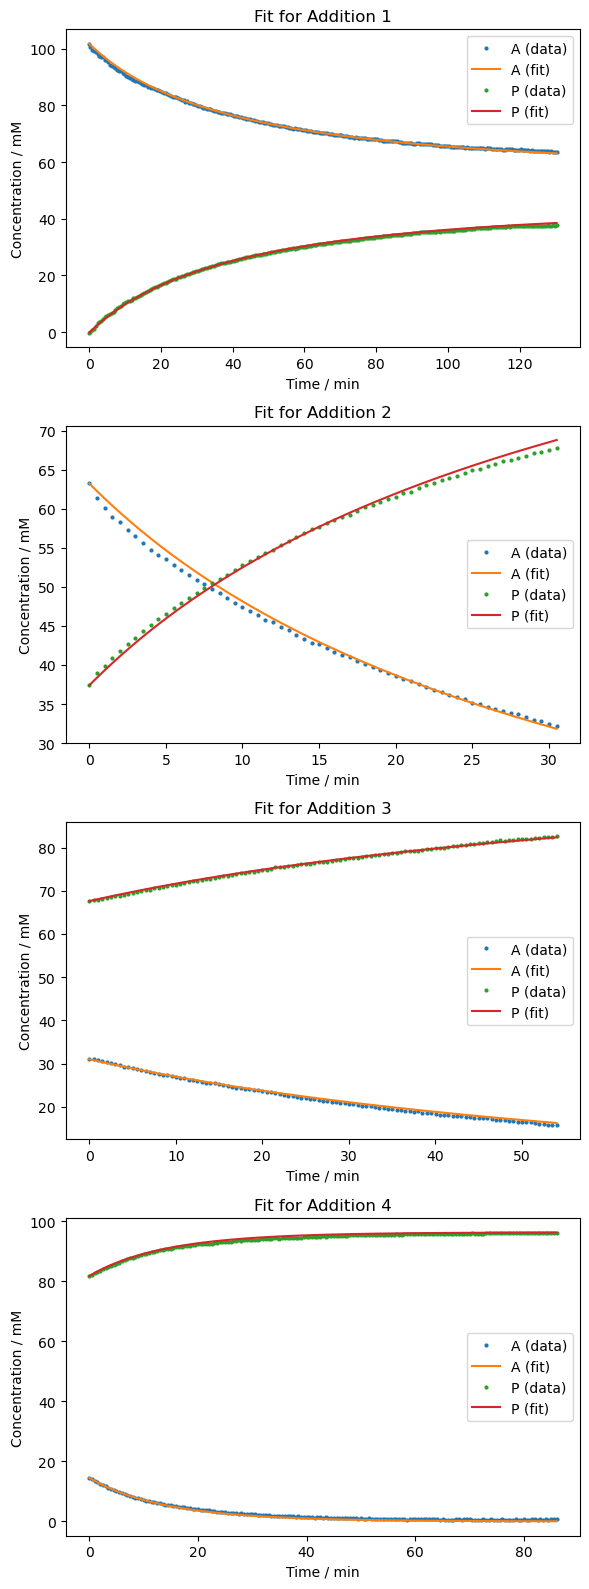

Combined best-fit graph saved as: Results_C1\plots\C1_E4a.tiff


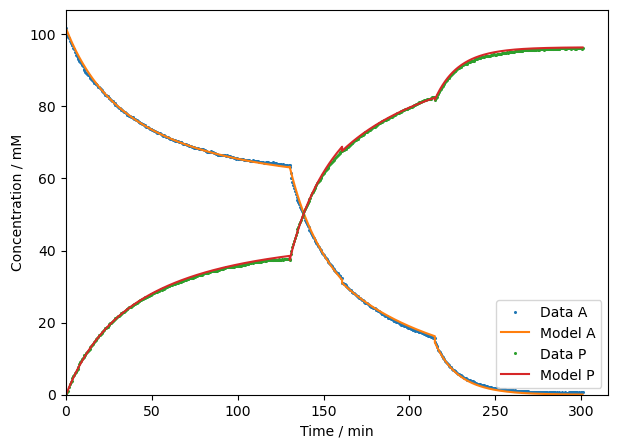

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0  C1_E4a 0.003630520 0.024769844 0.001072026 0.999805137 0.999847094   

       RMSE_A      RMSE_P  RMSE_total  
0 0.440160566 0.364654364 0.402407465

Dataset being analysed: C1_E4b.xlsx
Number of datapoints per SAKE period: [275, 48, 110, 628]


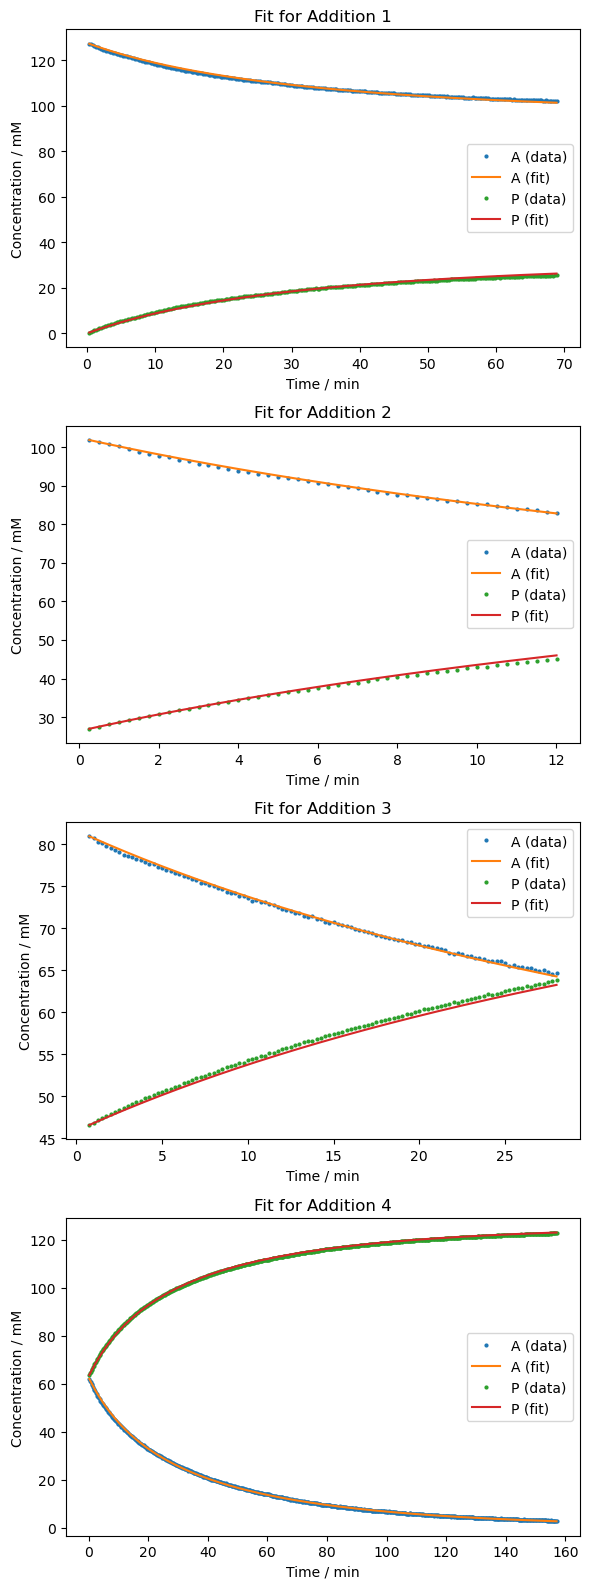

Combined best-fit graph saved as: Results_C1\plots\C1_E4b.tiff


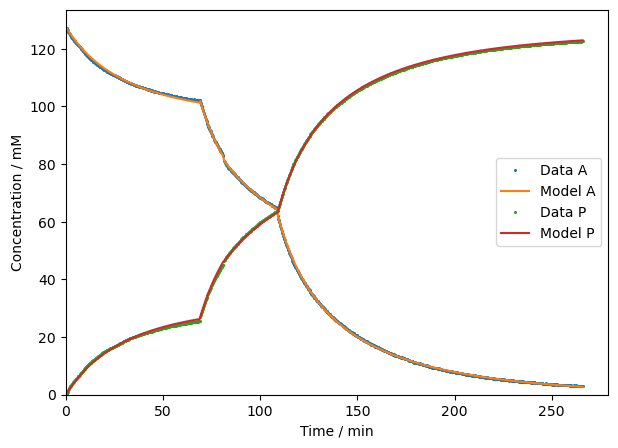

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0  C1_E4b 0.003684687 0.028996214 0.001161145 0.999952108 0.999925024   

       RMSE_A      RMSE_P  RMSE_total  
0 0.300647652 0.367564835 0.334106244

Dataset being analysed: C1_E5.xlsx
Number of datapoints per SAKE period: [195, 42, 72, 306]


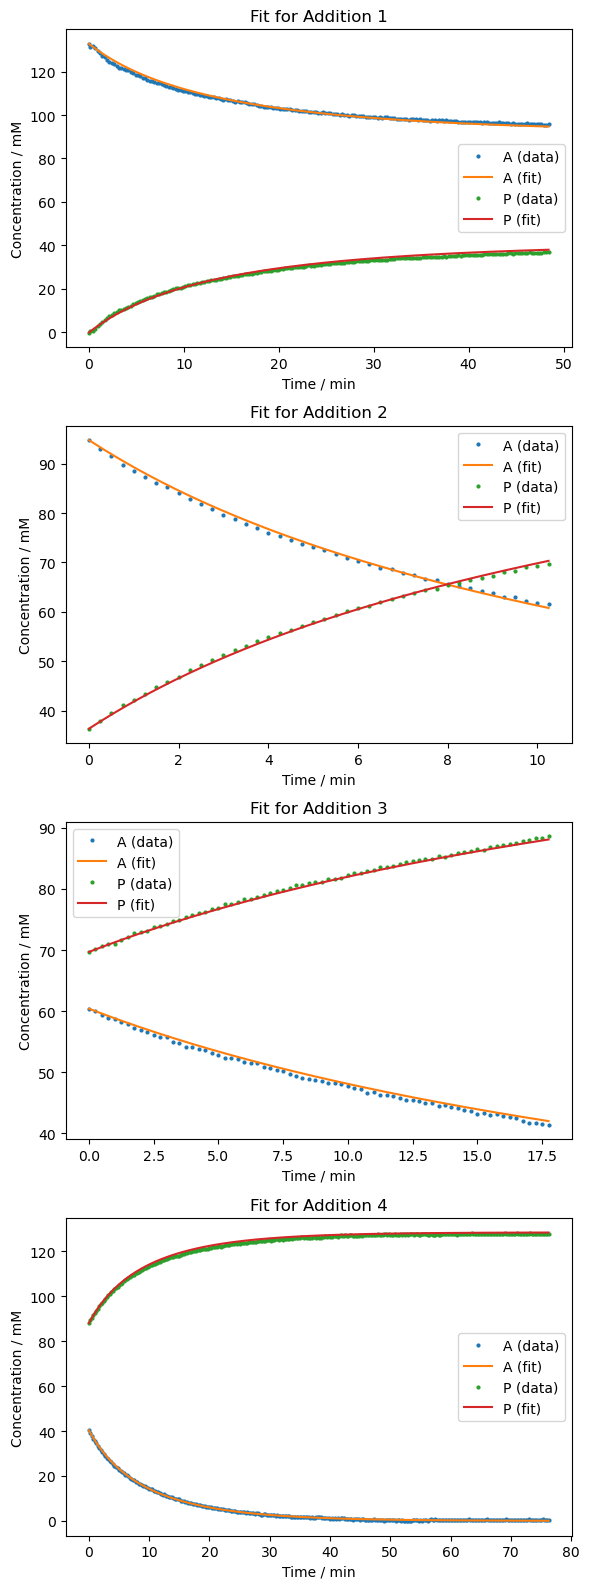

Combined best-fit graph saved as: Results_C1\plots\C1_E5.tiff


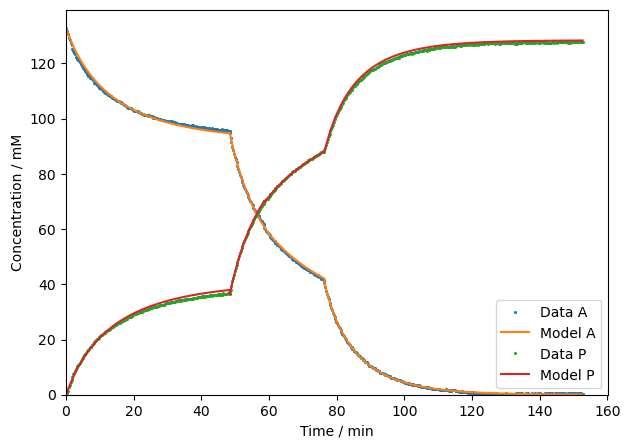

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C1_E5 0.008578955 0.049348883 0.001407627 0.999869077 0.999742582   

       RMSE_A      RMSE_P  RMSE_total  
0 0.516075952 0.692692268 0.604384110

Dataset being analysed: C1_E6.xlsx
Number of datapoints per SAKE period: [51, 21, 42, 244]


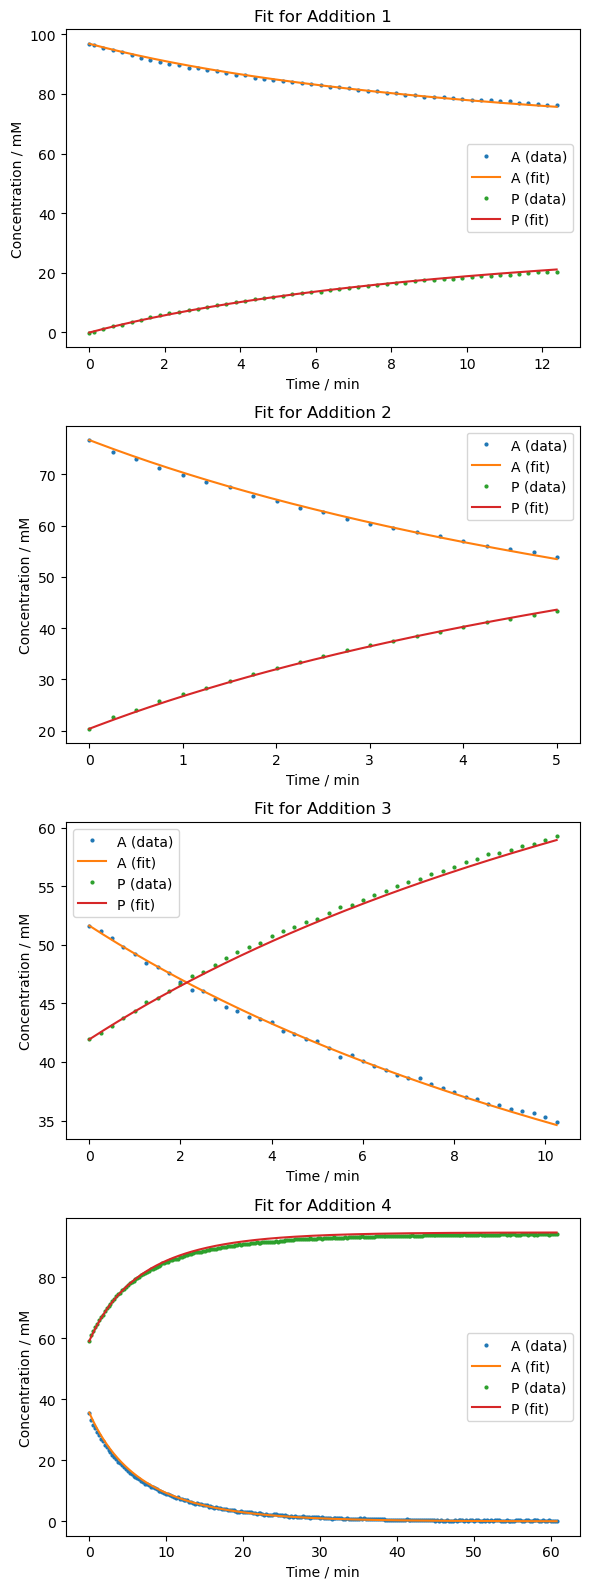

Combined best-fit graph saved as: Results_C1\plots\C1_E6.tiff


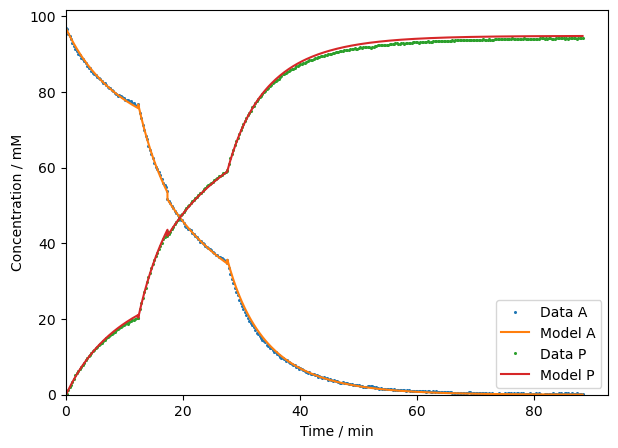

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C1_E6 0.015454911 0.054364686 0.001665428 0.999859191 0.999522871   

       RMSE_A      RMSE_P  RMSE_total  
0 0.364997731 0.652852540 0.508925136

Dataset being analysed: C1_E7.xlsx
Number of datapoints per SAKE period: [99, 21, 63, 198]


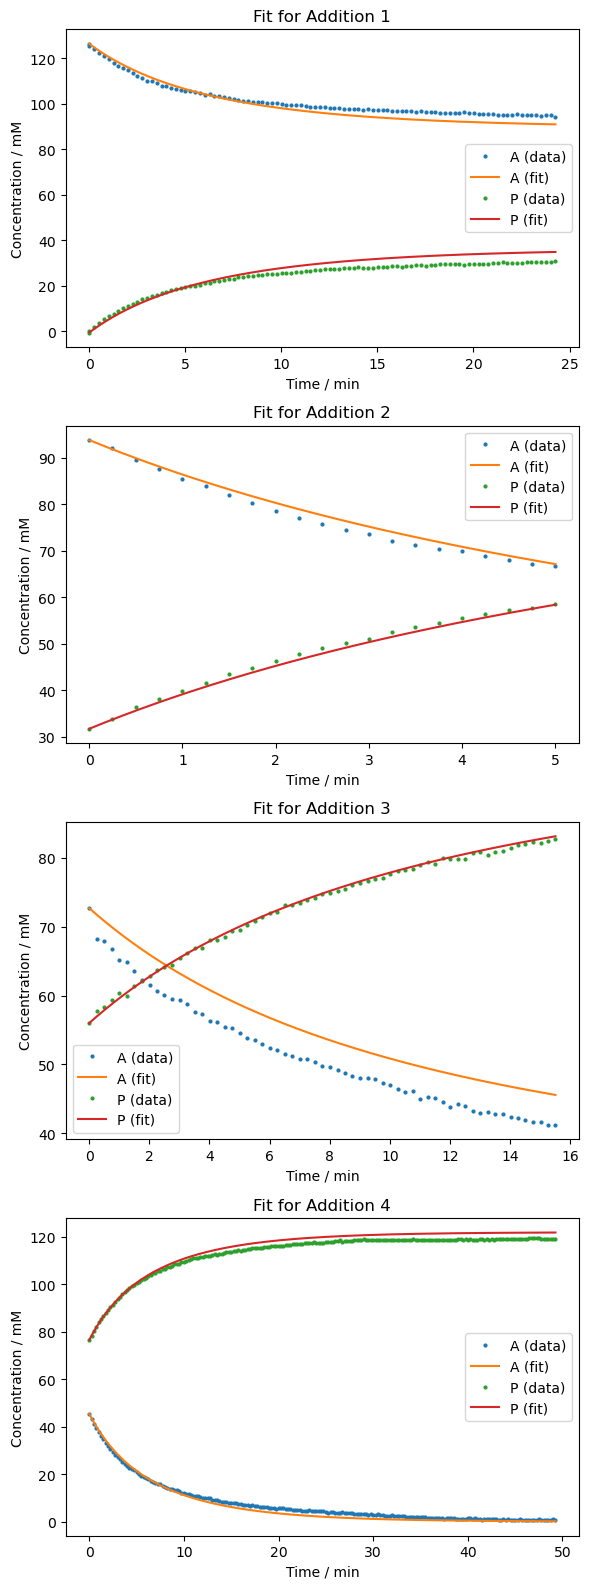

Combined best-fit graph saved as: Results_C1\plots\C1_E7.tiff


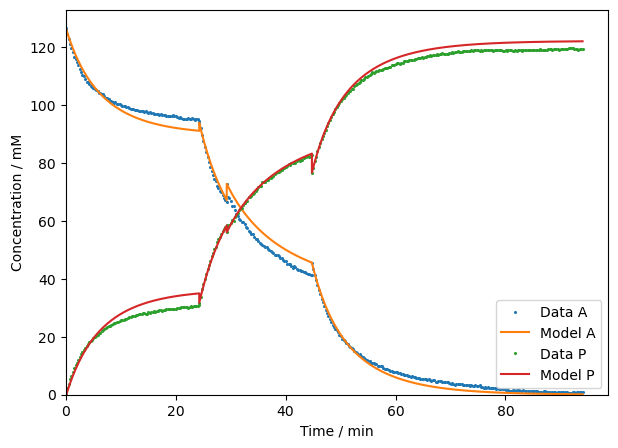

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C1_E7 0.022571504 0.000000167 0.000001000 0.996564751 0.996967187   

       RMSE_A      RMSE_P  RMSE_total  
0 2.410965677 2.157649756 2.284307716

In [9]:
results_S3_C1 = []
folder_C1 = "Results_C1"

os.makedirs(folder_C1, exist_ok=True)

for path in Experiment_paths_C1:
    print("\033[1mDataset being analysed:\033[0m", os.path.basename(path))

    df_params = fit_and_analyse_selected_3parameter_model(
        path,
        convert_to_SI=True,
        save_combined_plot=True,
        combined_plot_name=Path(path).stem,
        figure_folder=os.path.join(folder_C1, "plots"),
    )

    dataset_name = Path(path).stem
    df_params.insert(0, "Dataset", dataset_name)

    print("Best-fit parameters:")
    display(df_params)

    results_S3_C1.append(df_params)

output_path = os.path.join(folder_C1, "C1_kinetic_modelling_results.xlsx")

# One sheet with all datasets stacked
final_df = pd.concat(results_S3_C1, ignore_index=True)
final_df.to_excel(output_path, index=False)


### Campaign 2: Hammett study for 1a-h and 2a

In [10]:
Experiment_names_C2=[i for i in Experiment_names if i[1]=='2']
Experiment_paths_C2=[path_datasets+i+'.xlsx' for i in Experiment_names_C2]

Dataset being analysed: C2_E1.xlsx
Number of datapoints per SAKE period: [1010, 885, 1013, 2693]


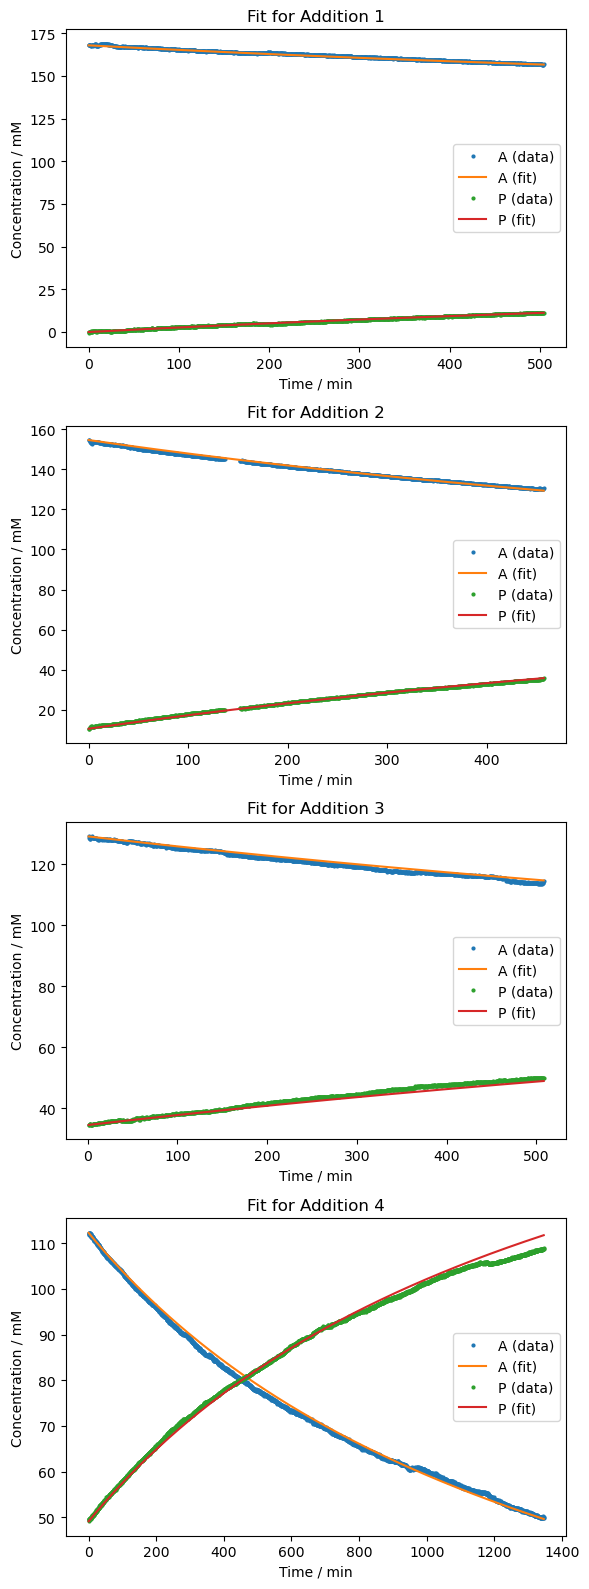

Combined best-fit graph saved as: Results_C2\plots\C2_E1.tiff


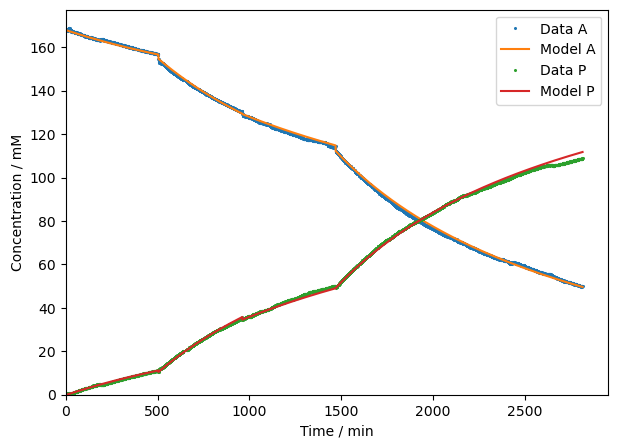

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C2_E1 0.000072830 0.000056537 0.001723718 0.999635463 0.999330491   

       RMSE_A      RMSE_P  RMSE_total  
0 0.724633276 0.911251709 0.817942492

Dataset being analysed: C2_E2.xlsx
Number of datapoints per SAKE period: [817, 189, 235, 1858]


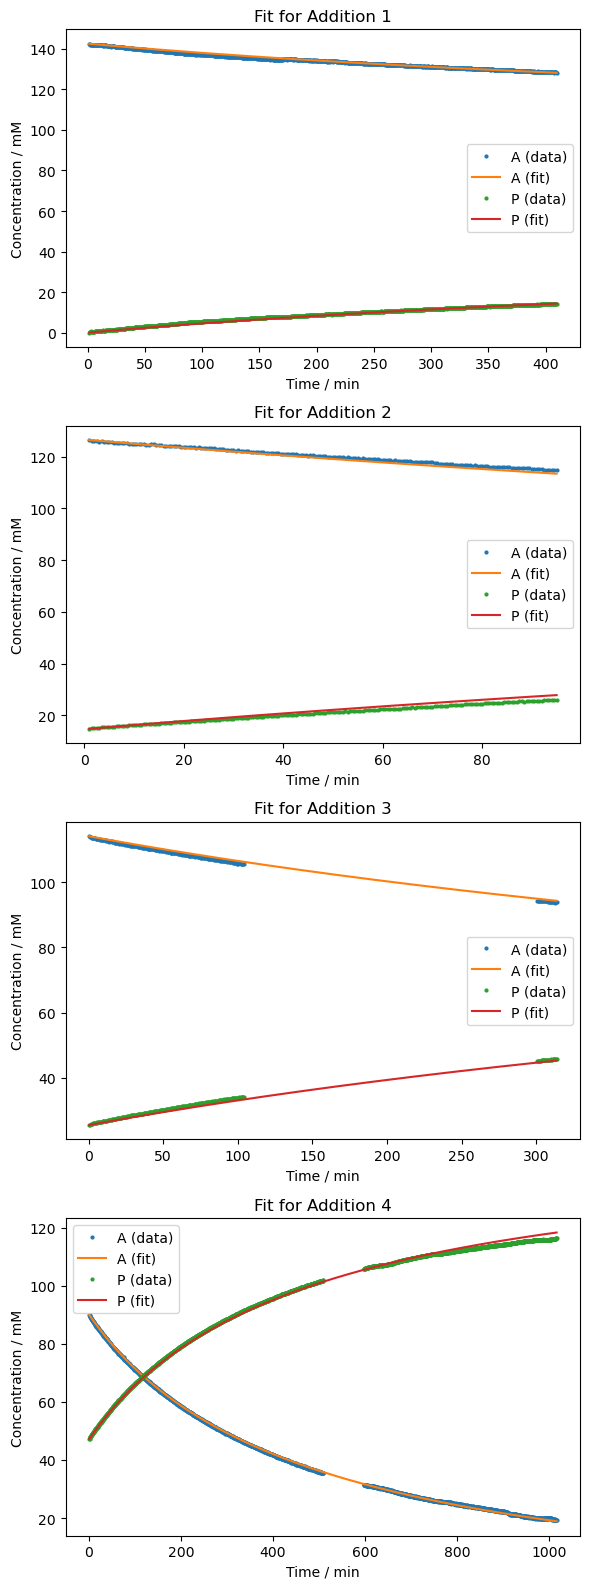

Combined best-fit graph saved as: Results_C2\plots\C2_E2.tiff


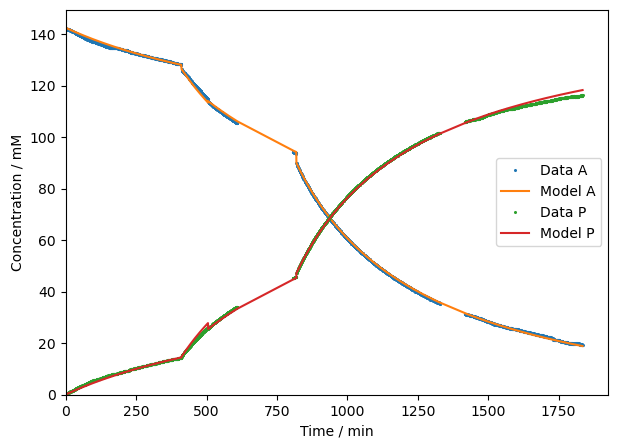

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C2_E2 0.000129472 0.000887038 0.002837510 0.999894773 0.999682074   

       RMSE_A      RMSE_P  RMSE_total  
0 0.460301462 0.757217799 0.608759631

Dataset being analysed: C2_E3.xlsx
Number of datapoints per SAKE period: [387, 100, 146, 467]


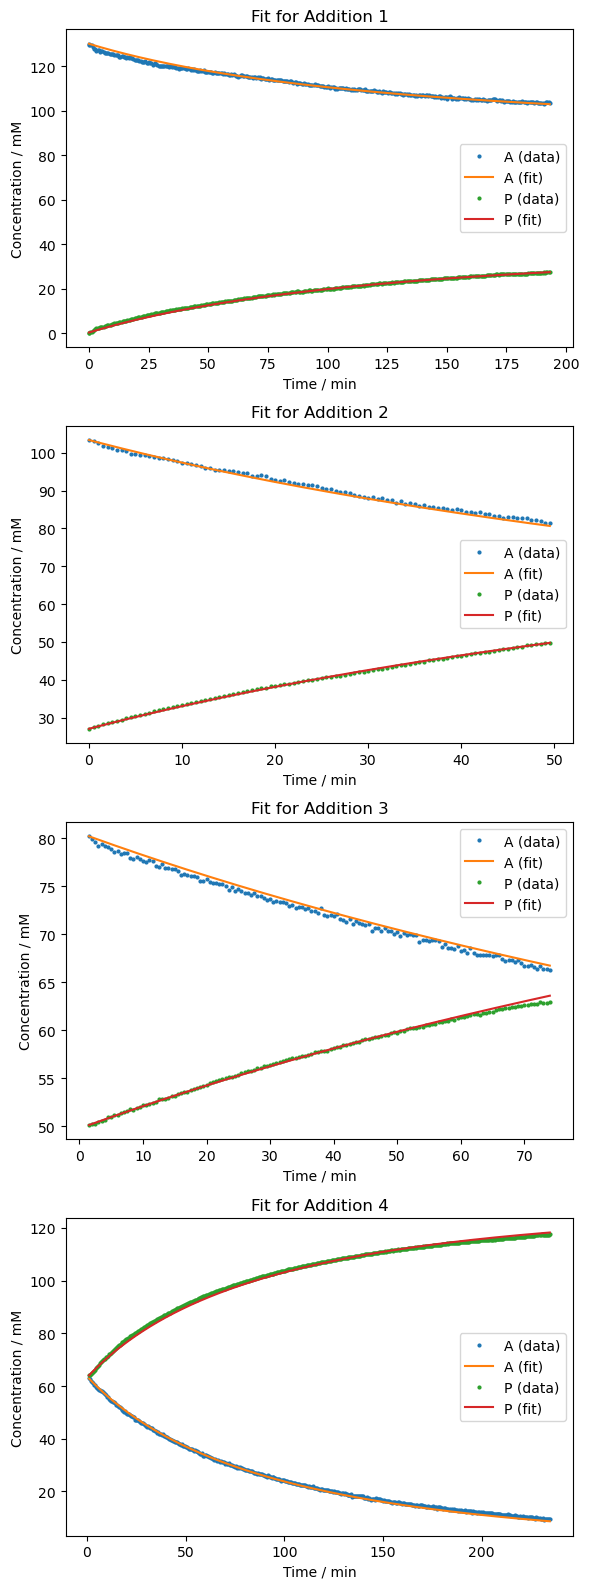

Combined best-fit graph saved as: Results_C2\plots\C2_E3.tiff


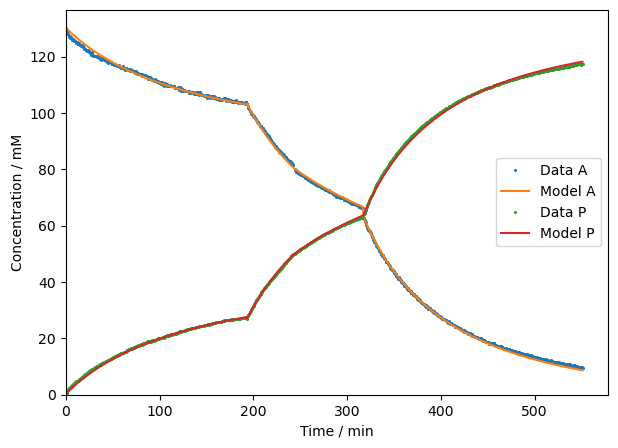

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C2_E3 0.001003355 0.003783652 0.002564144 0.999737619 0.999802410   

       RMSE_A      RMSE_P  RMSE_total  
0 0.653868879 0.547080162 0.600474520

Dataset being analysed: C2_E4.xlsx
Number of datapoints per SAKE period: [625, 111, 379, 1234]


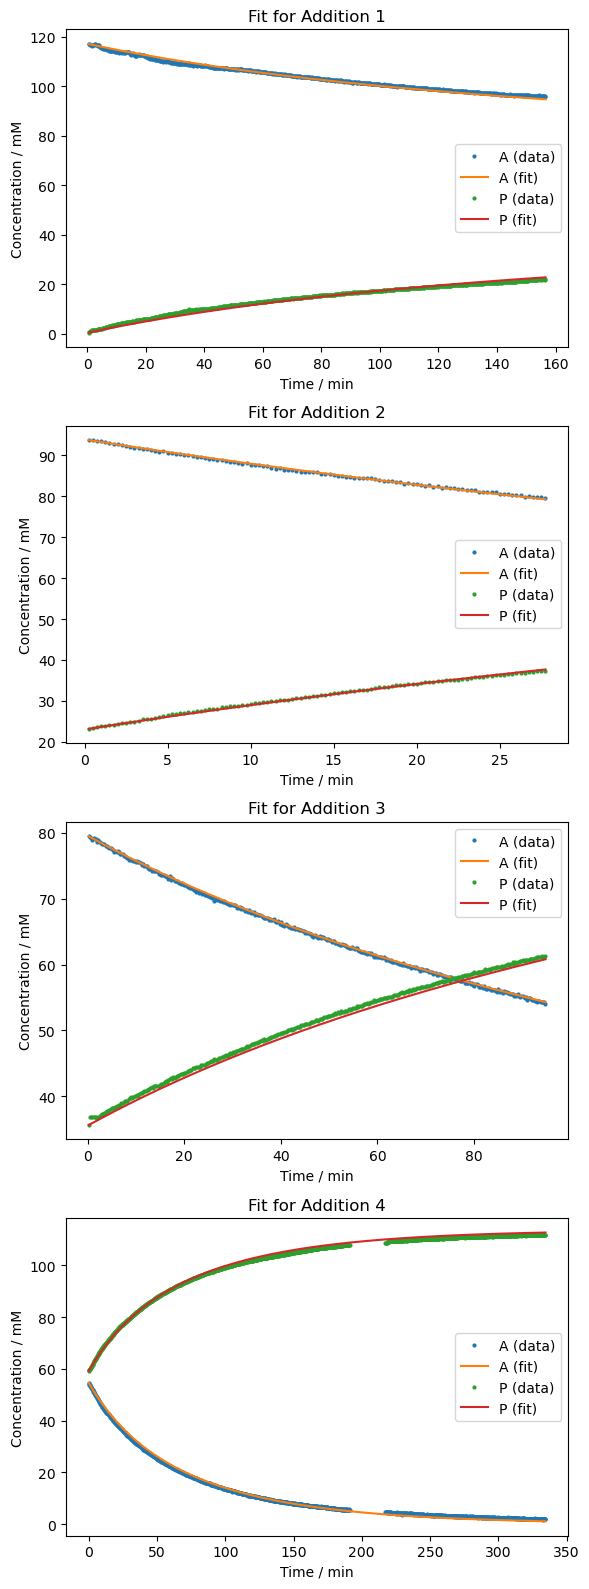

Combined best-fit graph saved as: Results_C2\plots\C2_E4.tiff


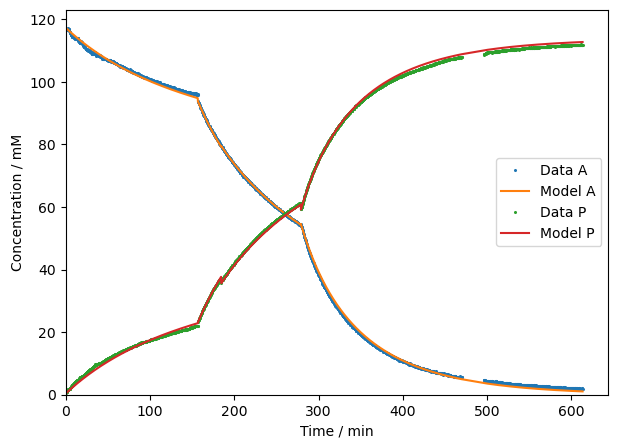

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C2_E4 0.000773193 0.003542765 0.000538438 0.999759291 0.999638970   

       RMSE_A      RMSE_P  RMSE_total  
0 0.640364524 0.745938548 0.693151536

Dataset being analysed: C2_E5.xlsx
Number of datapoints per SAKE period: [515, 252, 273, 500]


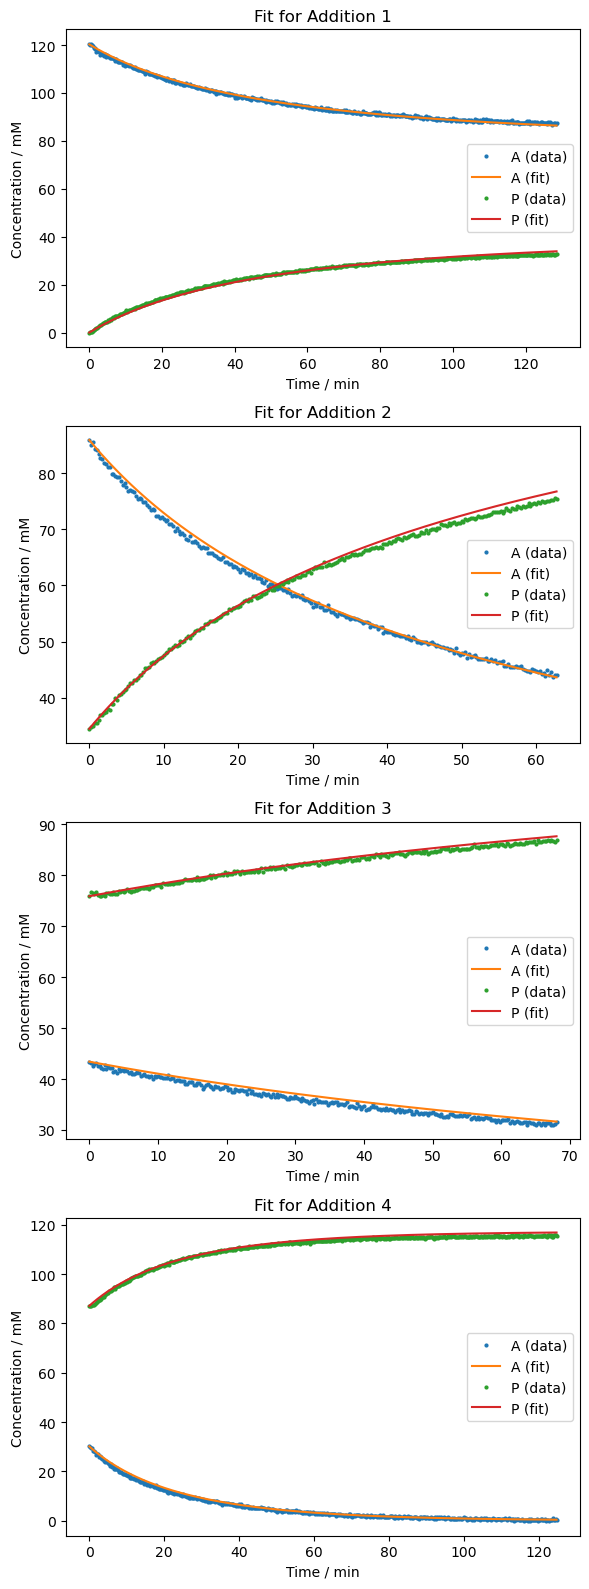

Combined best-fit graph saved as: Results_C2\plots\C2_E5.tiff


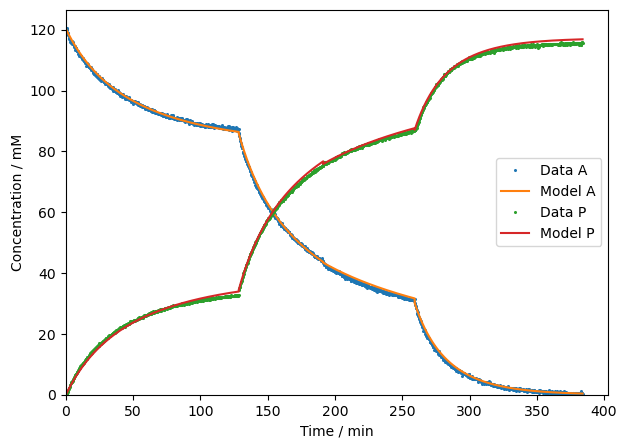

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C2_E5 0.002581647 0.017911846 0.001310256 0.999715655 0.999583071   

       RMSE_A      RMSE_P  RMSE_total  
0 0.644212384 0.745589711 0.694901047

Dataset being analysed: C2_E6.xlsx
Number of datapoints per SAKE period: [177, 47, 183, 803]


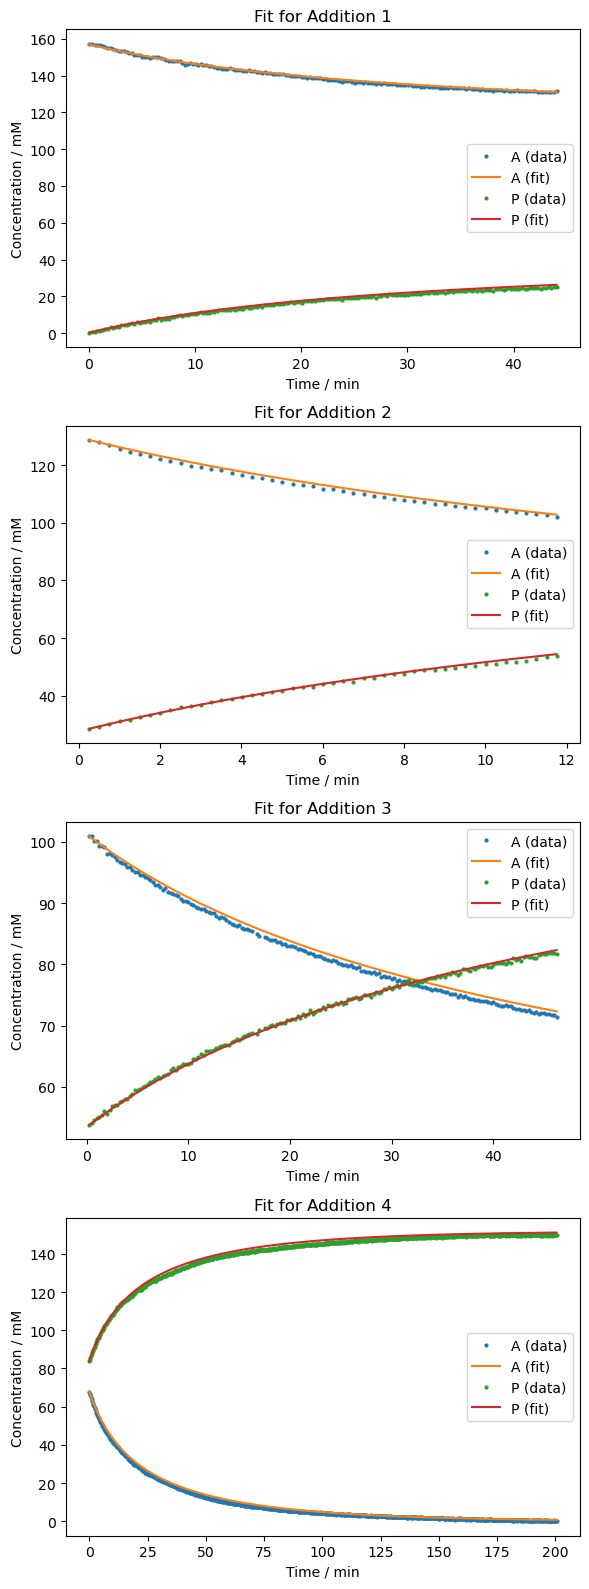

Combined best-fit graph saved as: Results_C2\plots\C2_E6.tiff


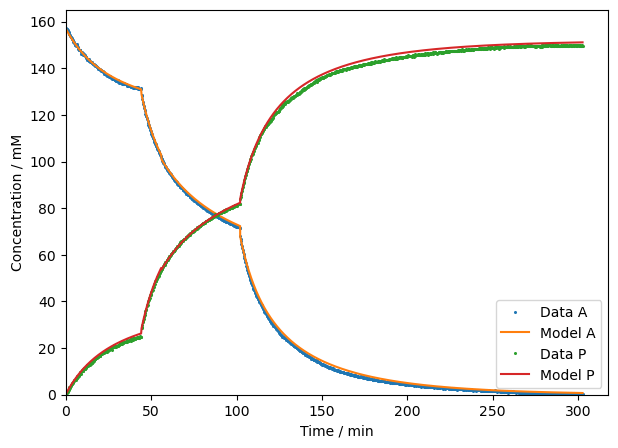

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C2_E6 0.002709838 0.038902094 0.000948438 0.999720909 0.999382566   

       RMSE_A      RMSE_P  RMSE_total  
0 0.863079122 1.219308795 1.041193959

Dataset being analysed: C2_E7a.xlsx
Number of datapoints per SAKE period: [31, 17, 42, 20]


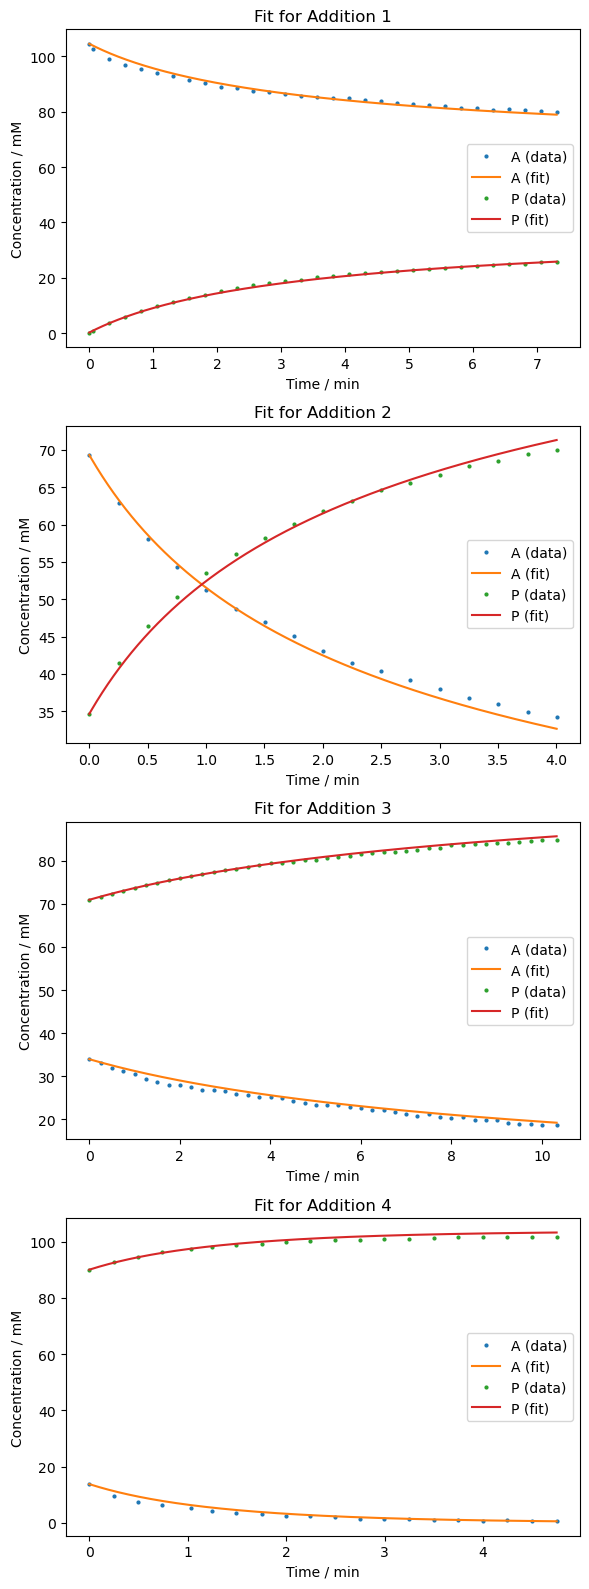

Combined best-fit graph saved as: Results_C2\plots\C2_E7a.tiff


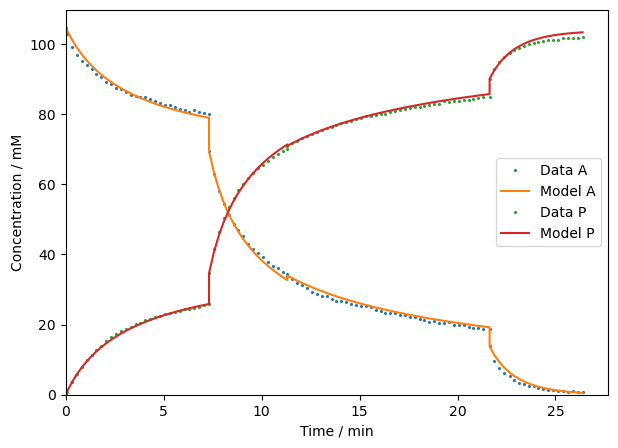

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0  C2_E7a 0.018547243 1.086054823 0.001002032 0.999257089 0.999609260   

       RMSE_A      RMSE_P  RMSE_total  
0 0.866198380 0.614287450 0.740242915

Dataset being analysed: C2_E7b.xlsx
Number of datapoints per SAKE period: [33, 16, 31, 34]


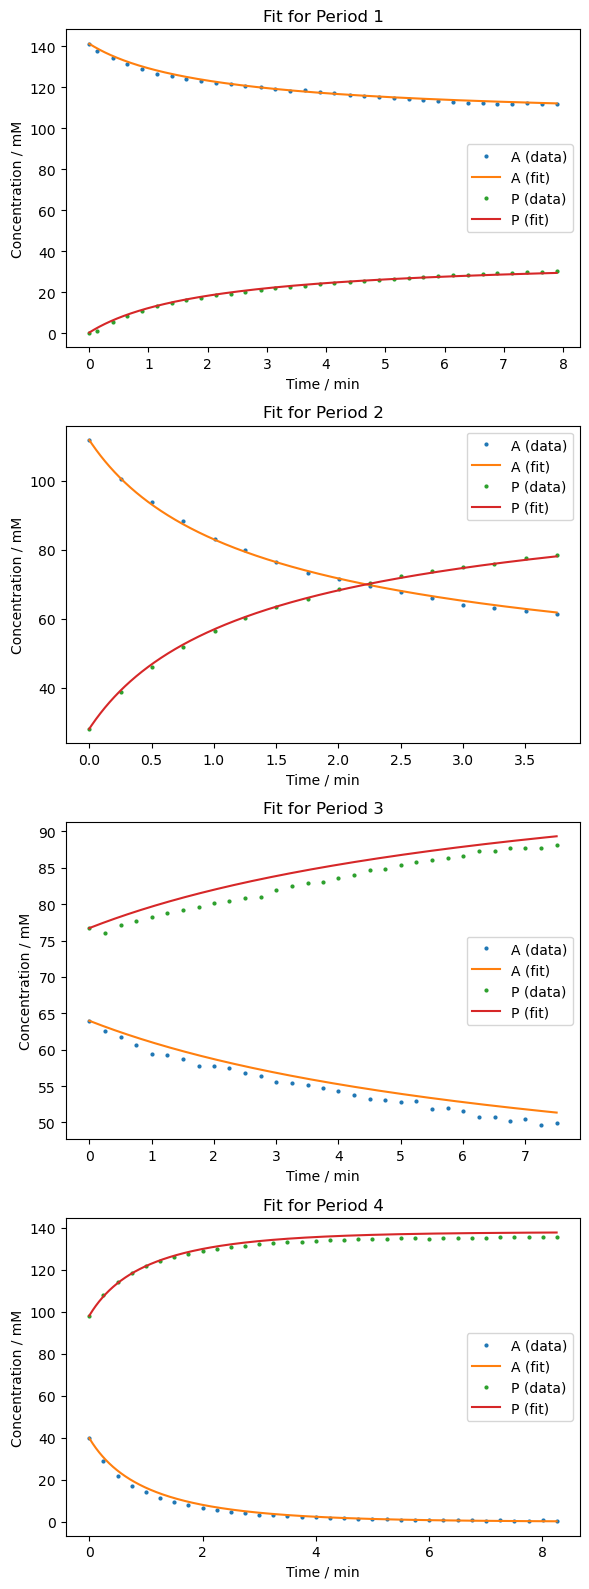

Combined best-fit graph saved as: Results_C2\plots\C2_E7b.tiff


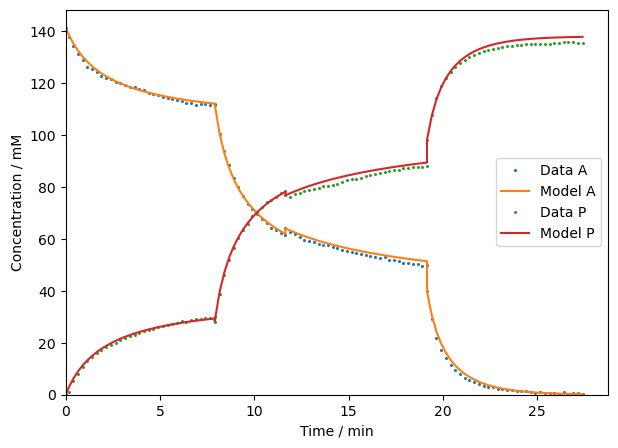

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0  C2_E7b 0.019755430 1.307948670 0.001012898 0.999526489 0.999126535   

       RMSE_A      RMSE_P  RMSE_total  
0 0.976556065 1.272495581 1.124525823

In [11]:
results_S3_C2 = []
folder_C2 = "Results_C2"

os.makedirs(folder_C2, exist_ok=True)

for path in Experiment_paths_C2:
    print("\033[1mDataset being analysed:\033[0m", os.path.basename(path))

    df_params = fit_and_analyse_selected_3parameter_model(
        path,
        convert_to_SI=True,
        save_combined_plot=True,
        combined_plot_name=Path(path).stem,
        figure_folder=os.path.join(folder_C2, "plots"),
    )

    dataset_name = Path(path).stem
    df_params.insert(0, "Dataset", dataset_name)

    print("Best-fit parameters:")
    display(df_params)

    results_S3_C2.append(df_params)

output_path = os.path.join(folder_C2, "C2_kinetic_modelling_results.xlsx")

# One sheet with all datasets stacked
final_df = pd.concat(results_S3_C2, ignore_index=True)
final_df.to_excel(output_path, index=False)


### Campaign 3: Brønsted Study for 1a with Various Cyclic Secondary Amines 2b-f

In [12]:
Experiment_names_C3=[i for i in Experiment_names if i[1]=='3']
Experiment_paths_C3=[path_datasets+i+'.xlsx' for i in Experiment_names_C3]

Dataset being analysed: C3_E1.xlsx
Number of datapoints per SAKE period: [27, 13, 24, 17]


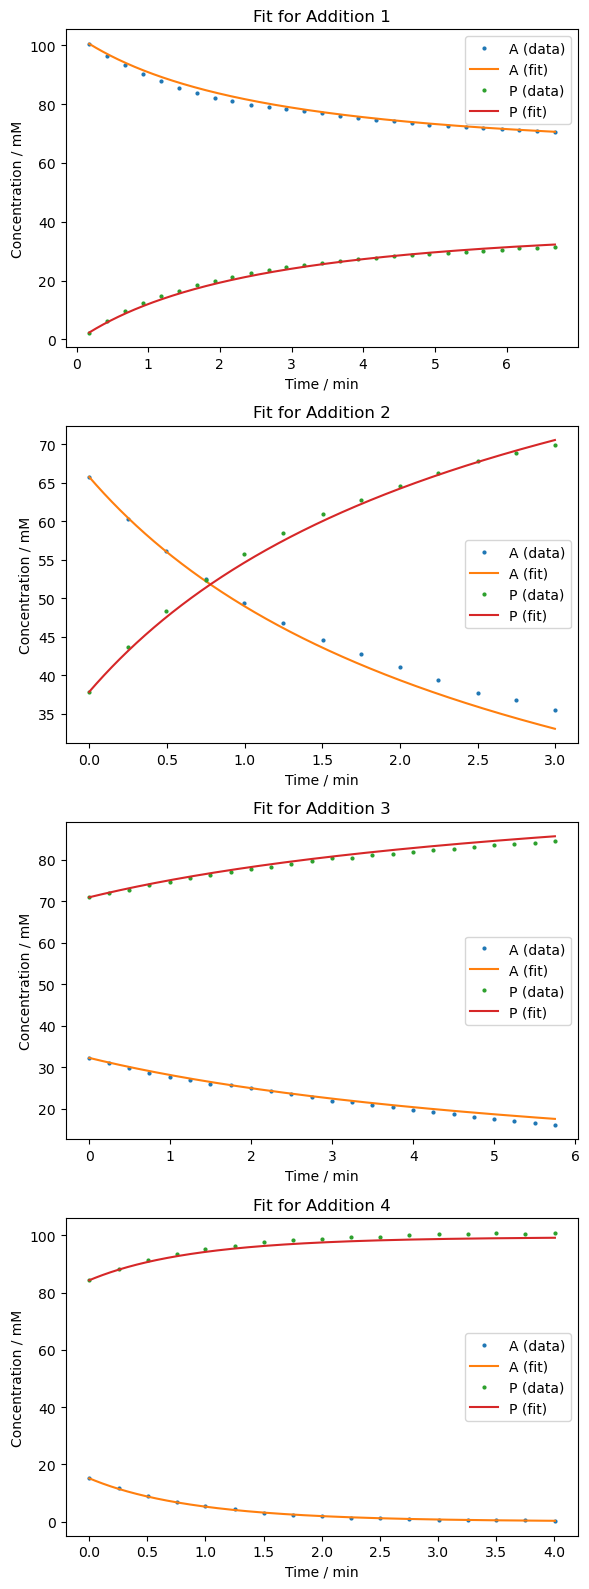

Combined best-fit graph saved as: Results_C3\plots\C3_E1.tiff


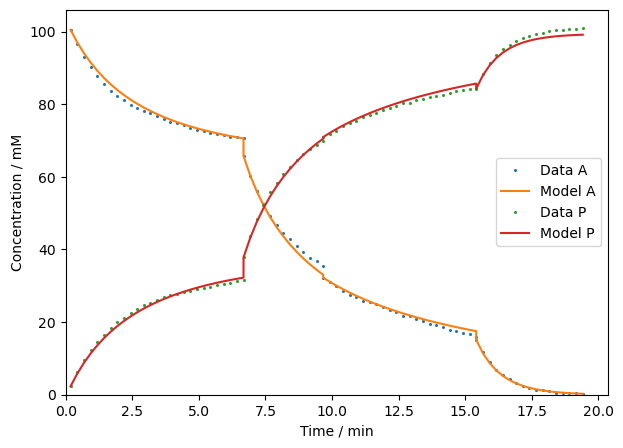

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C3_E1 0.057312296 0.400051845 0.000153849 0.999204552 0.999130134   

       RMSE_A      RMSE_P  RMSE_total  
0 0.857866091 0.880626906 0.869246498

Dataset being analysed: C3_E2.xlsx
Number of datapoints per SAKE period: [182, 50, 120, 458]


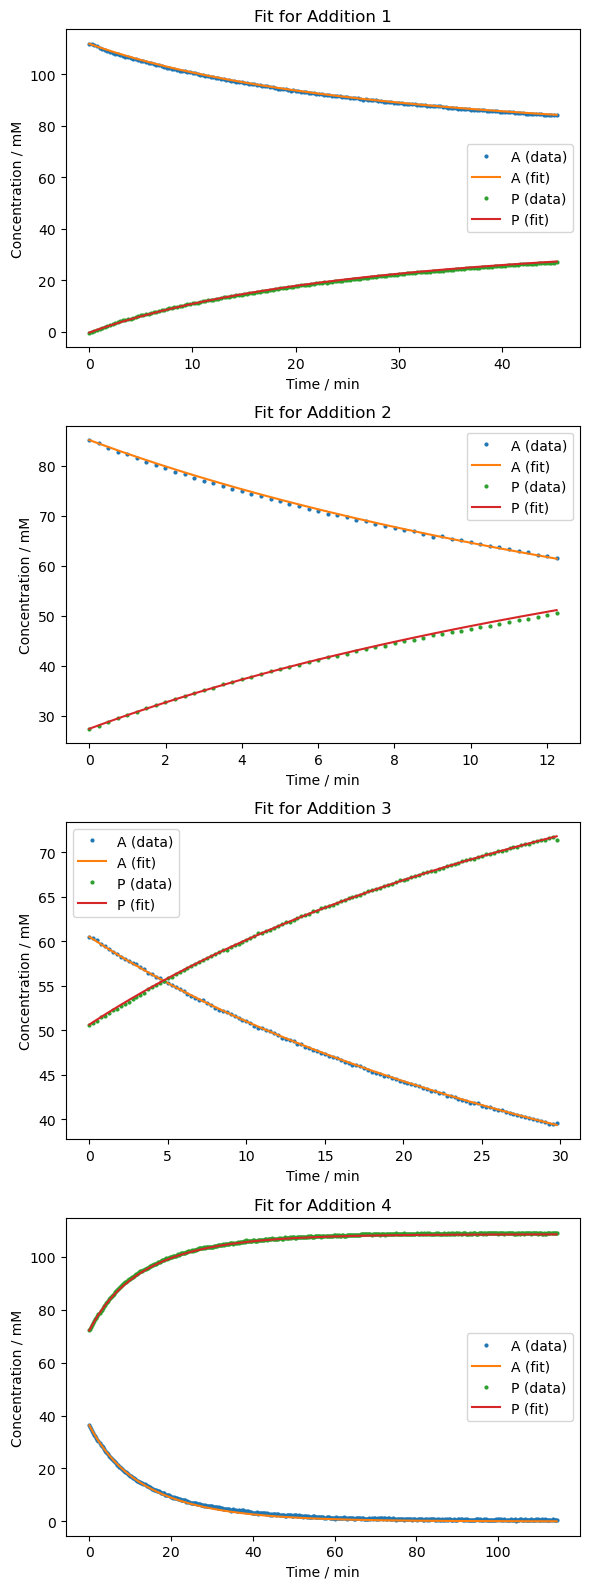

Combined best-fit graph saved as: Results_C3\plots\C3_E2.tiff


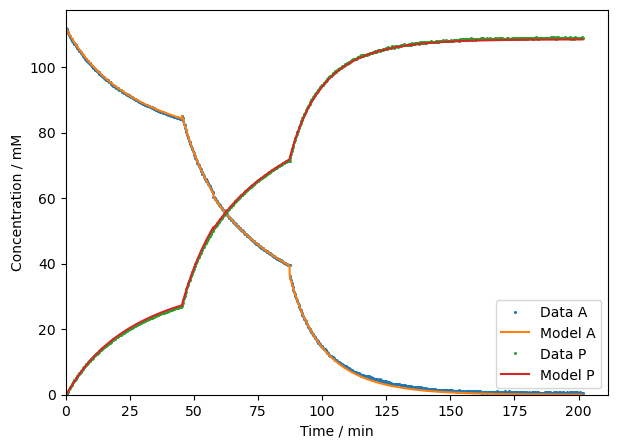

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C3_E2 0.005027920 0.021297499 0.000855682 0.999847788 0.999913049   

       RMSE_A      RMSE_P  RMSE_total  
0 0.468967724 0.346208565 0.407588145

Dataset being analysed: C3_E3.xlsx


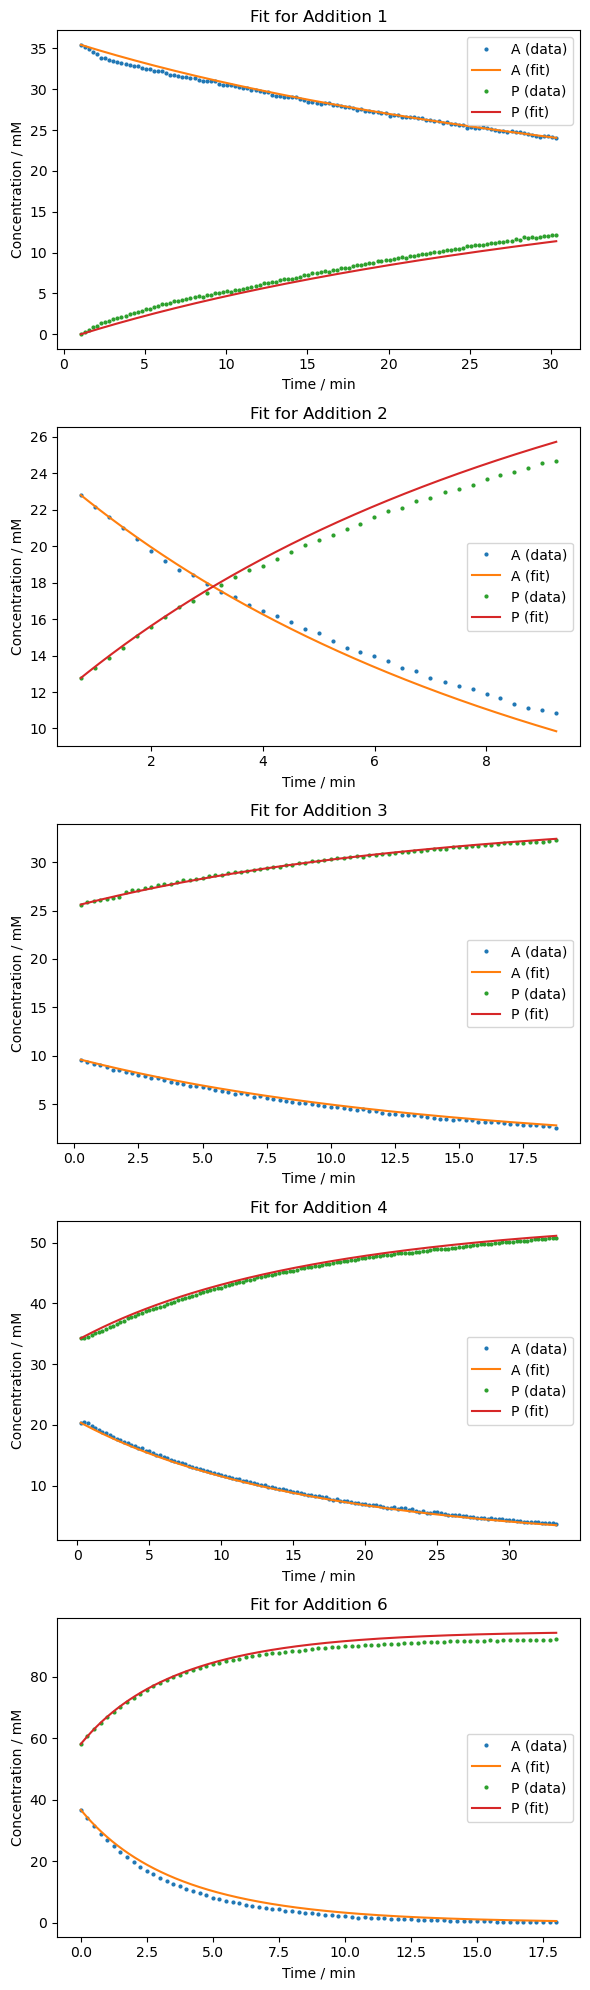

Combined best-fit graph saved as: Results_C3\plots\C3_E3.tiff


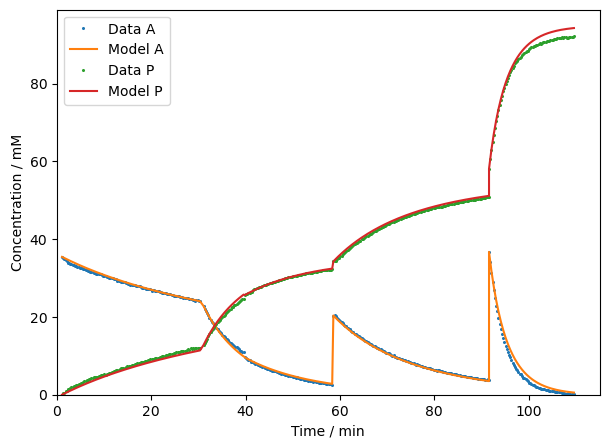

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C3_E3 0.003885079 0.009887014 0.001015050 0.996742519 0.999174691   

       RMSE_A      RMSE_P  RMSE_total  
0 0.601851045 0.765785766 0.683818406

Dataset being analysed: C3_E4.xlsx
Number of datapoints per SAKE period: [710, 142, 524, 1947]


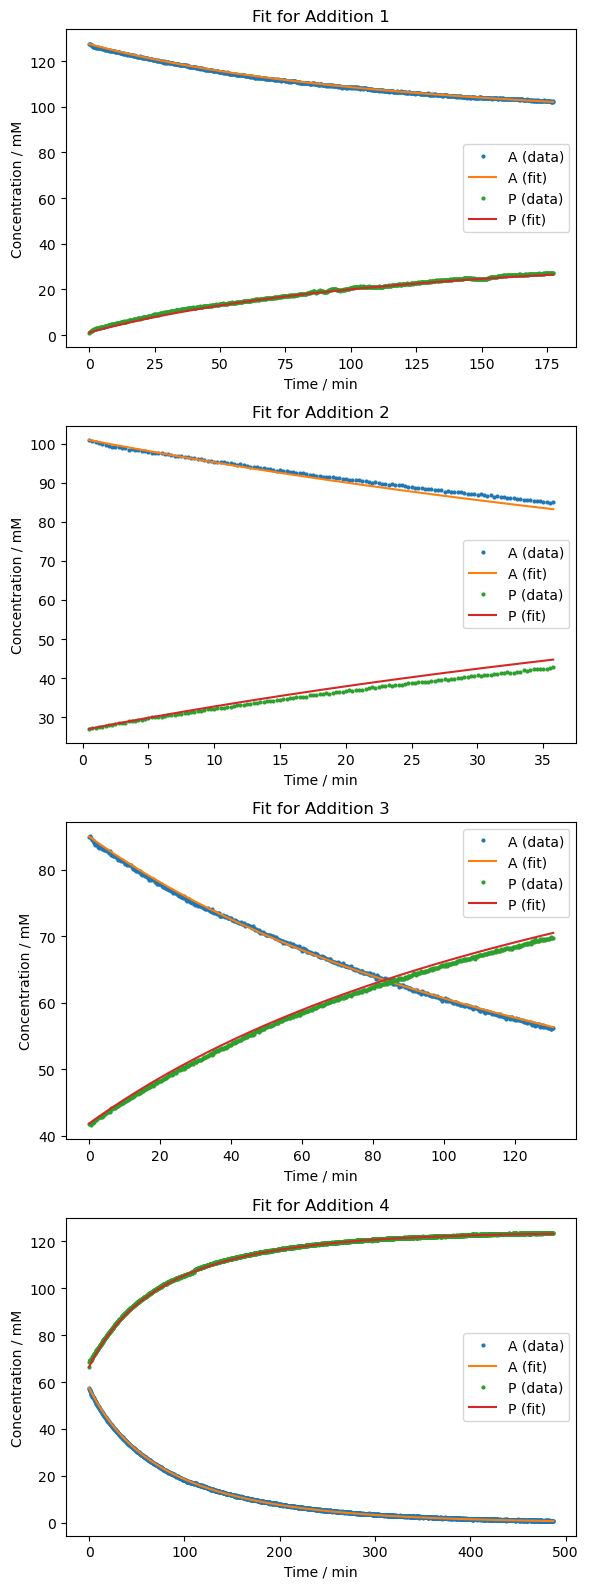

Combined best-fit graph saved as: Results_C3\plots\C3_E4.tiff


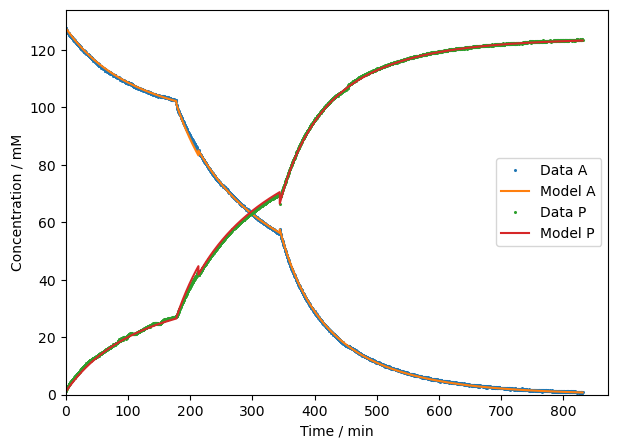

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C3_E4 0.001035816 0.004060774 0.000517258 0.999938093 0.999828930   

       RMSE_A      RMSE_P  RMSE_total  
0 0.343470268 0.547285307 0.445377787

Dataset being analysed: C3_E5.xlsx
Number of datapoints per SAKE period: [940, 335, 1358, 2402]


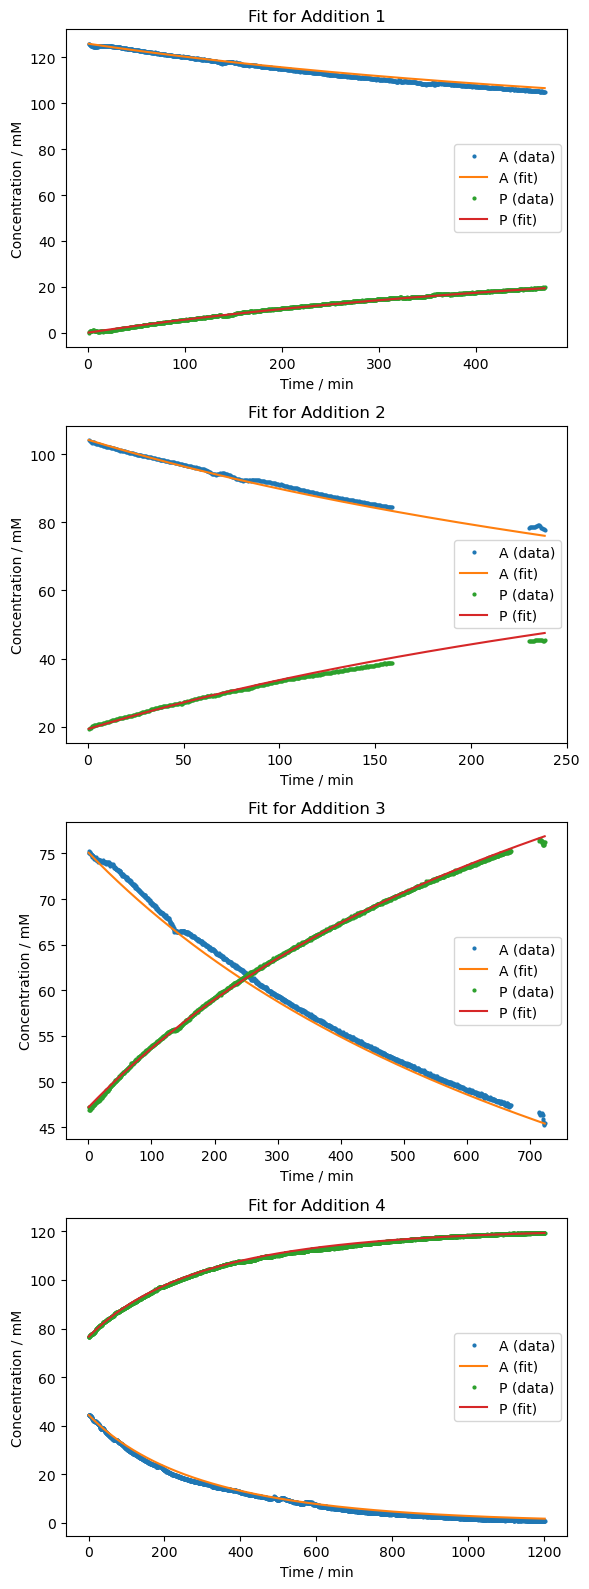

Combined best-fit graph saved as: Results_C3\plots\C3_E5.tiff


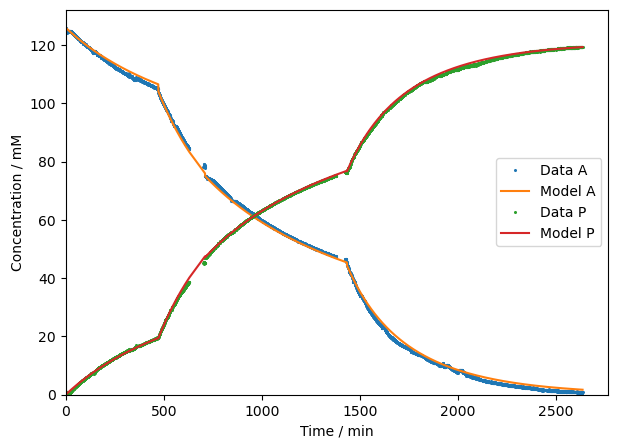

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C3_E5 0.000156470 0.000859230 0.000699945 0.999460681 0.999890521   

       RMSE_A      RMSE_P  RMSE_total  
0 0.960807264 0.410451225 0.685629244

In [13]:
results_S3_C3 = []
folder_C3 = "Results_C3"

os.makedirs(folder_C3, exist_ok=True)

for path in Experiment_paths_C3:
    print("\033[1mDataset being analysed:\033[0m", os.path.basename(path))
    if 'C3_E3' in path:
            df_params = fit_and_analyse_selected_3parameter_model_piperazine(
            path,
            convert_to_SI=True,
            save_combined_plot=True,
            combined_plot_name=Path(path).stem,
            figure_folder=os.path.join(folder_C3, "plots"),
            )
    else:
        df_params = fit_and_analyse_selected_3parameter_model(
            path,
            convert_to_SI=True,
            save_combined_plot=True,
            combined_plot_name=Path(path).stem,
            figure_folder=os.path.join(folder_C3, "plots"),
            )

    dataset_name = Path(path).stem
    df_params.insert(0, "Dataset", dataset_name)

    print("Best-fit parameters:")
    display(df_params)

    results_S3_C3.append(df_params)

output_path = os.path.join(folder_C3, "C3_kinetic_modelling_results.xlsx")

# One sheet with all datasets stacked
final_df = pd.concat(results_S3_C3, ignore_index=True)
final_df.to_excel(output_path, index=False)


### Campaign 4: Solvents Effect Study

In [14]:
Experiment_names_C4=[i for i in Experiment_names if i[1]=='4']
Experiment_paths_C4=[path_datasets+i+'.xlsx' for i in Experiment_names_C4]

In [15]:
Experiment_paths_C4[-4:]

['C:\\Users\\test_gv\\OneDrive - Imperial College London\\PhD\\SAKE publication with SI material\\Cleaned Python Scripts for Github\\SAKE datasets\\C4_E8.xlsx',
 'C:\\Users\\test_gv\\OneDrive - Imperial College London\\PhD\\SAKE publication with SI material\\Cleaned Python Scripts for Github\\SAKE datasets\\C4_E9.xlsx',
 'C:\\Users\\test_gv\\OneDrive - Imperial College London\\PhD\\SAKE publication with SI material\\Cleaned Python Scripts for Github\\SAKE datasets\\C4_E10.xlsx',
 'C:\\Users\\test_gv\\OneDrive - Imperial College London\\PhD\\SAKE publication with SI material\\Cleaned Python Scripts for Github\\SAKE datasets\\C4_E11.xlsx']

Dataset being analysed: C4_E1a.xlsx
Number of datapoints per SAKE period: [1122, 614, 2951, 1708]


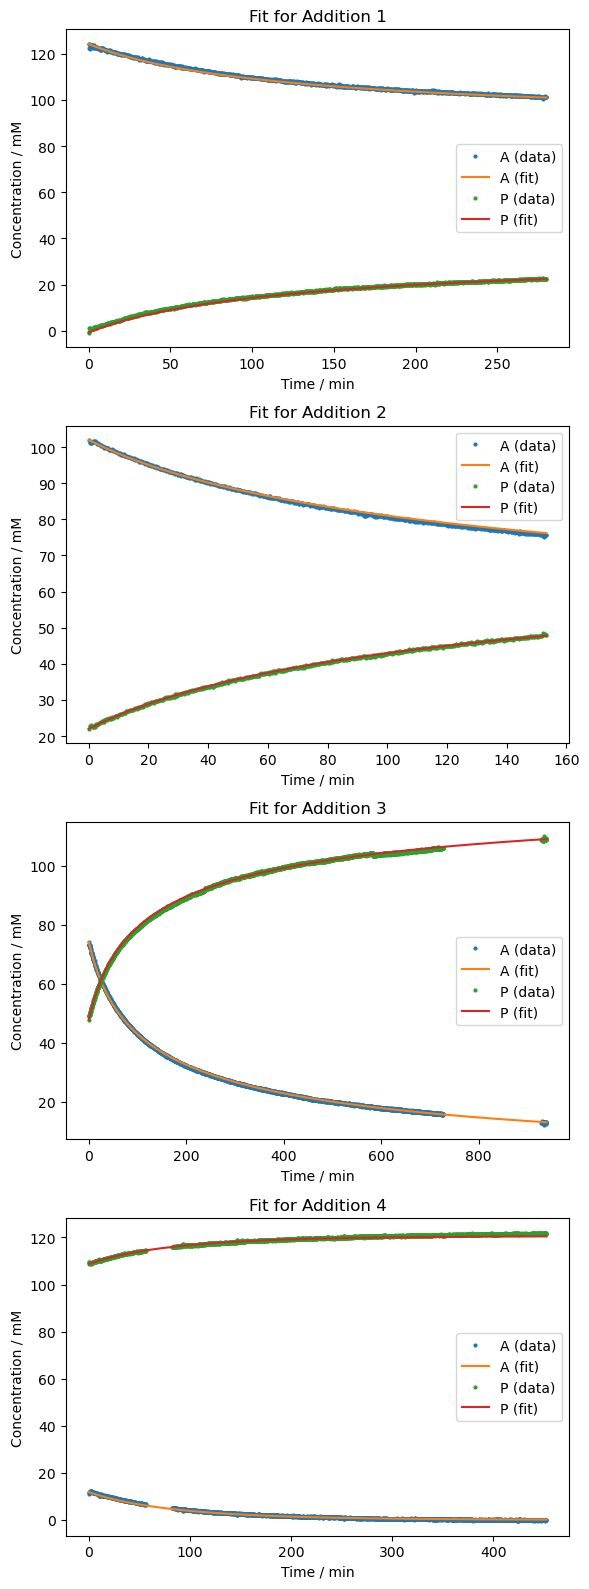

Combined best-fit graph saved as: Results_C4\plots\C4_E1a.tiff


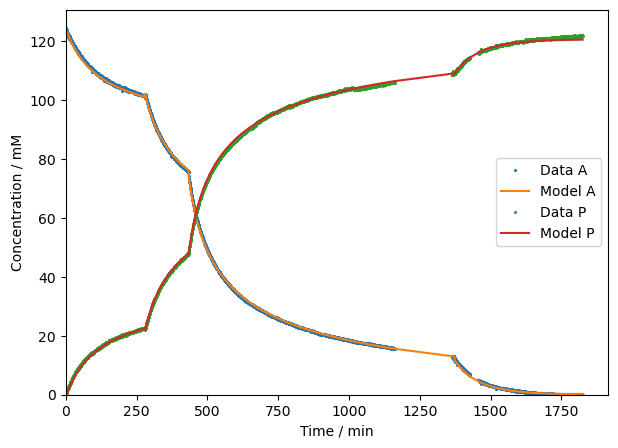

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0  C4_E1a 0.000526823 0.026043997 0.006250339 0.999932022 0.999859698   

       RMSE_A      RMSE_P  RMSE_total  
0 0.325384257 0.453510659 0.389447458

Dataset being analysed: C4_E1b.xlsx
Number of datapoints per SAKE period: [368, 1215, 1230]


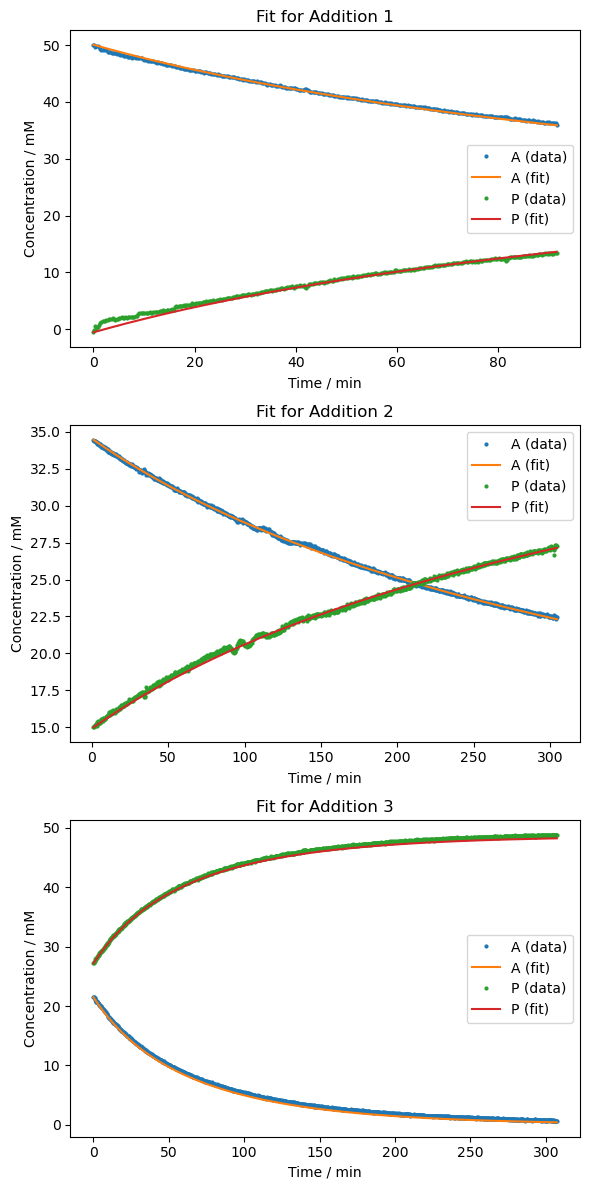

Combined best-fit graph saved as: Results_C4\plots\C4_E1b.tiff


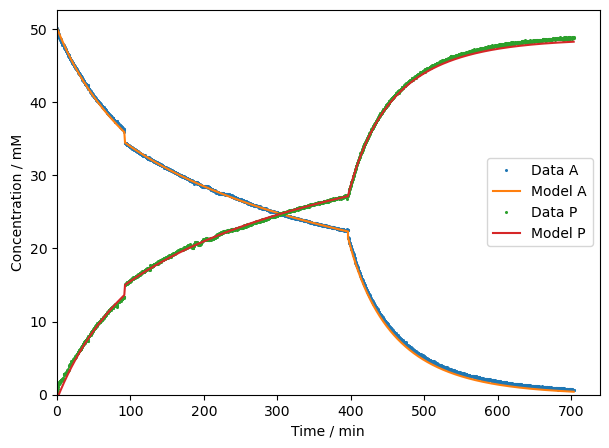

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0  C4_E1b 0.000547117 0.022325745 0.004285043 0.999631432 0.999408761   

       RMSE_A      RMSE_P  RMSE_total  
0 0.271938110 0.341689326 0.306813718

Dataset being analysed: C4_E2.xlsx
Number of datapoints per SAKE period: [4647, 933, 3580]


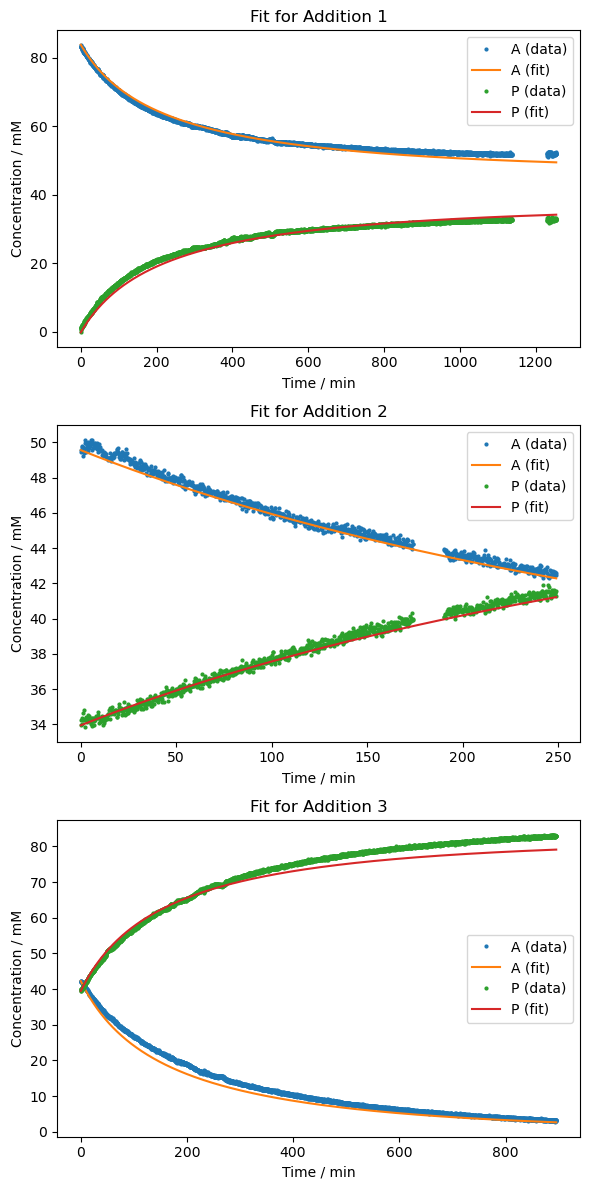

Combined best-fit graph saved as: Results_C4\plots\C4_E2.tiff


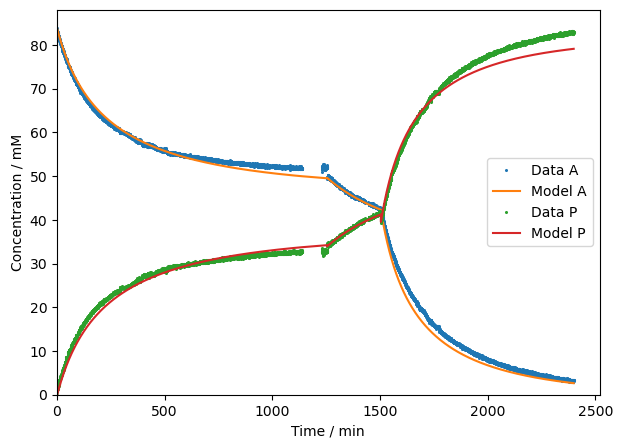

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C4_E2 0.000491226 0.014628454 0.000399459 0.996932829 0.994801611   

       RMSE_A      RMSE_P  RMSE_total  
0 1.261657766 1.675446814 1.468552290

Dataset being analysed: C4_E3.xlsx
Number of datapoints per SAKE period: [499, 116, 224, 1048]


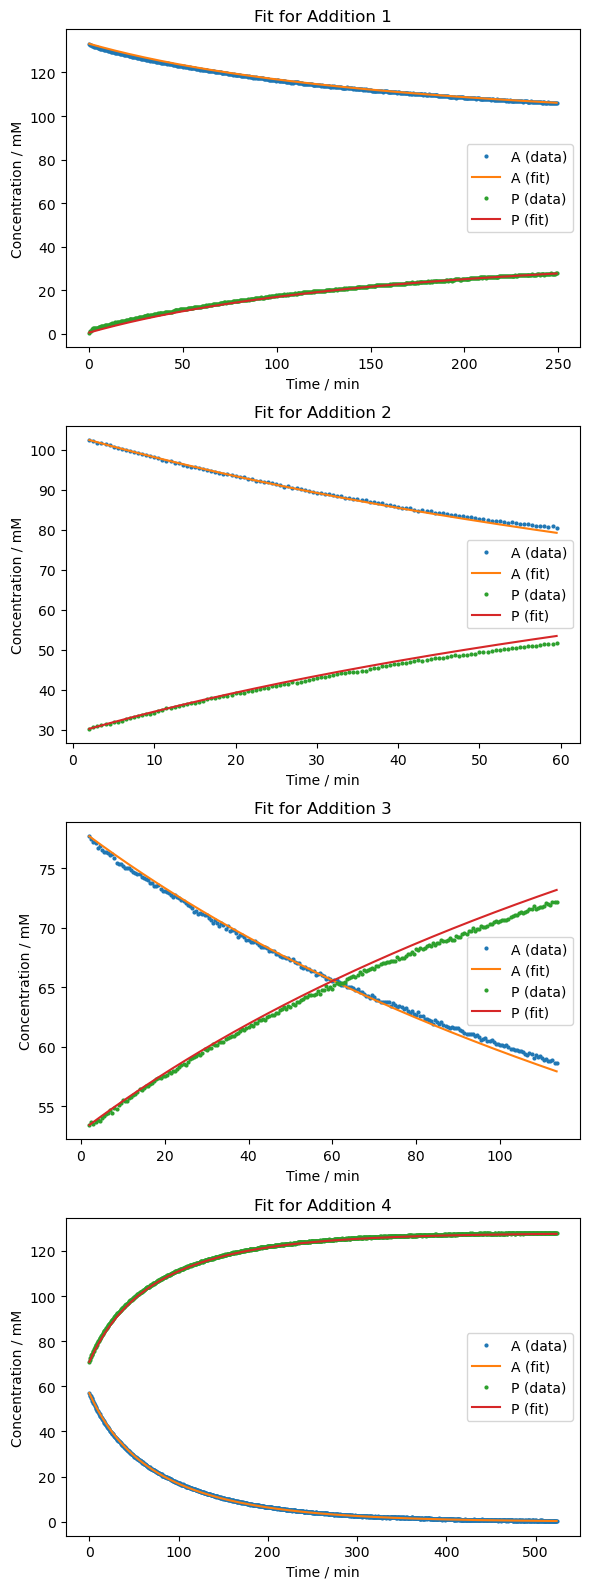

Combined best-fit graph saved as: Results_C4\plots\C4_E3.tiff


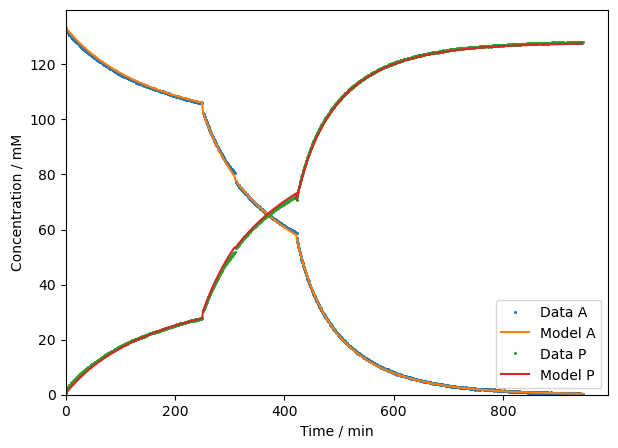

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C4_E3 0.000636570 0.004490715 0.000335924 0.999947131 0.999831376   

       RMSE_A      RMSE_P  RMSE_total  
0 0.347580276 0.590883908 0.469232092

Dataset being analysed: C4_E4.xlsx
Number of datapoints per SAKE period: [299, 205, 548, 226]


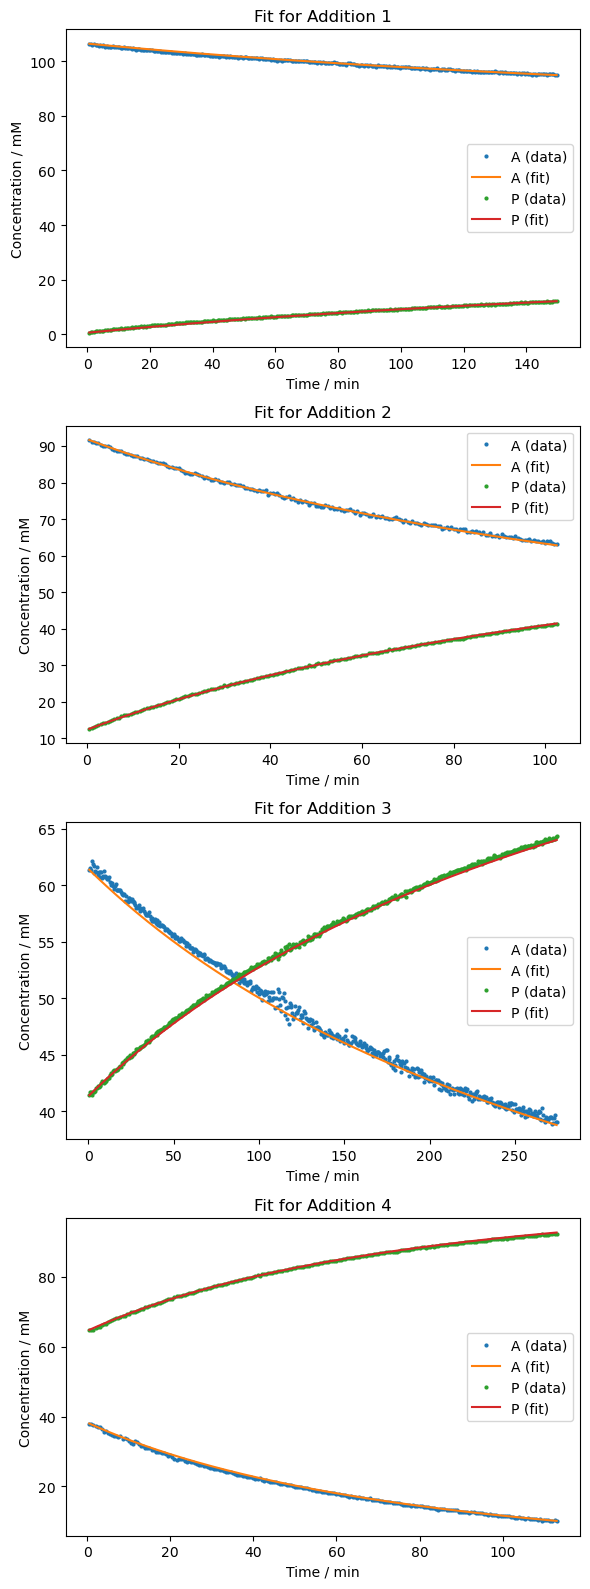

Combined best-fit graph saved as: Results_C4\plots\C4_E4.tiff


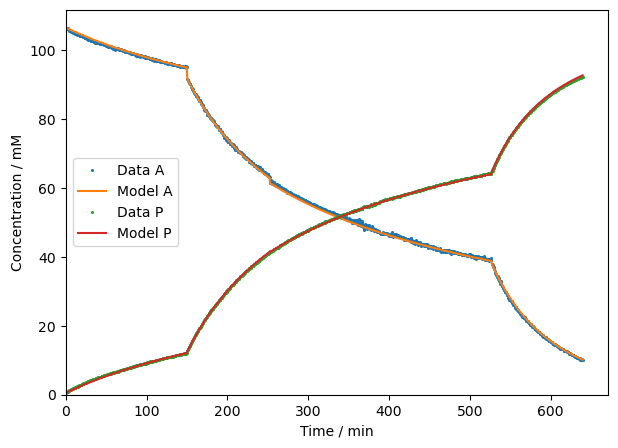

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C4_E4 0.000426011 0.005990093 0.000568893 0.999772441 0.999928095   

       RMSE_A      RMSE_P  RMSE_total  
0 0.422740160 0.224539927 0.323640044

Dataset being analysed: C4_E5.xlsx
Number of datapoints per SAKE period: [671, 1437, 2545]


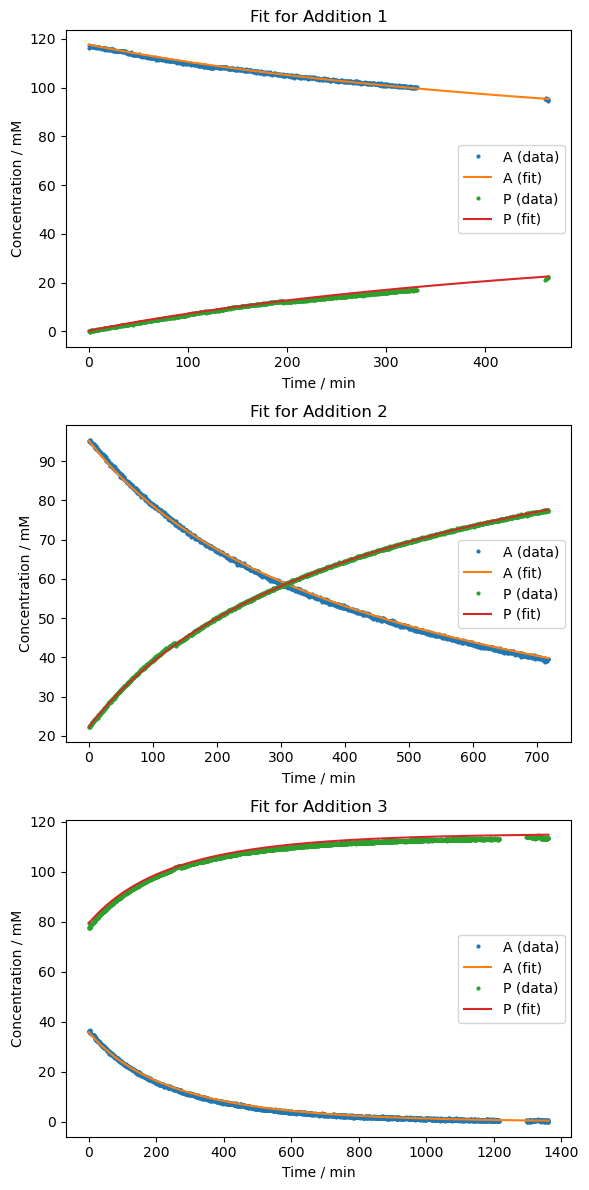

Combined best-fit graph saved as: Results_C4\plots\C4_E5.tiff


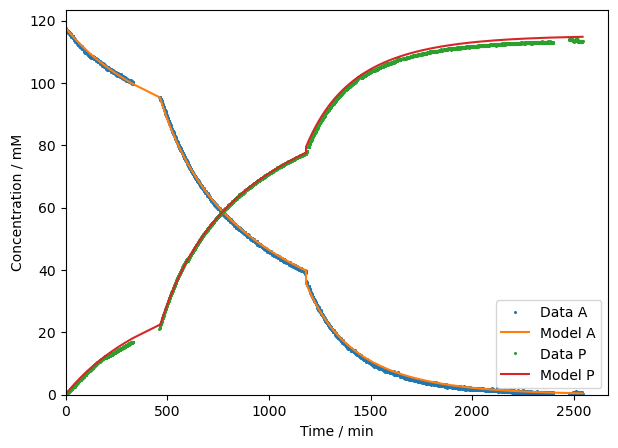

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C4_E5 0.000181678 0.001348337 0.002278979 0.999860468 0.999356148   

       RMSE_A      RMSE_P  RMSE_total  
0 0.450843483 0.930445532 0.690644508

Dataset being analysed: C4_E6.xlsx
Number of datapoints per SAKE period: [606, 783, 579, 164]


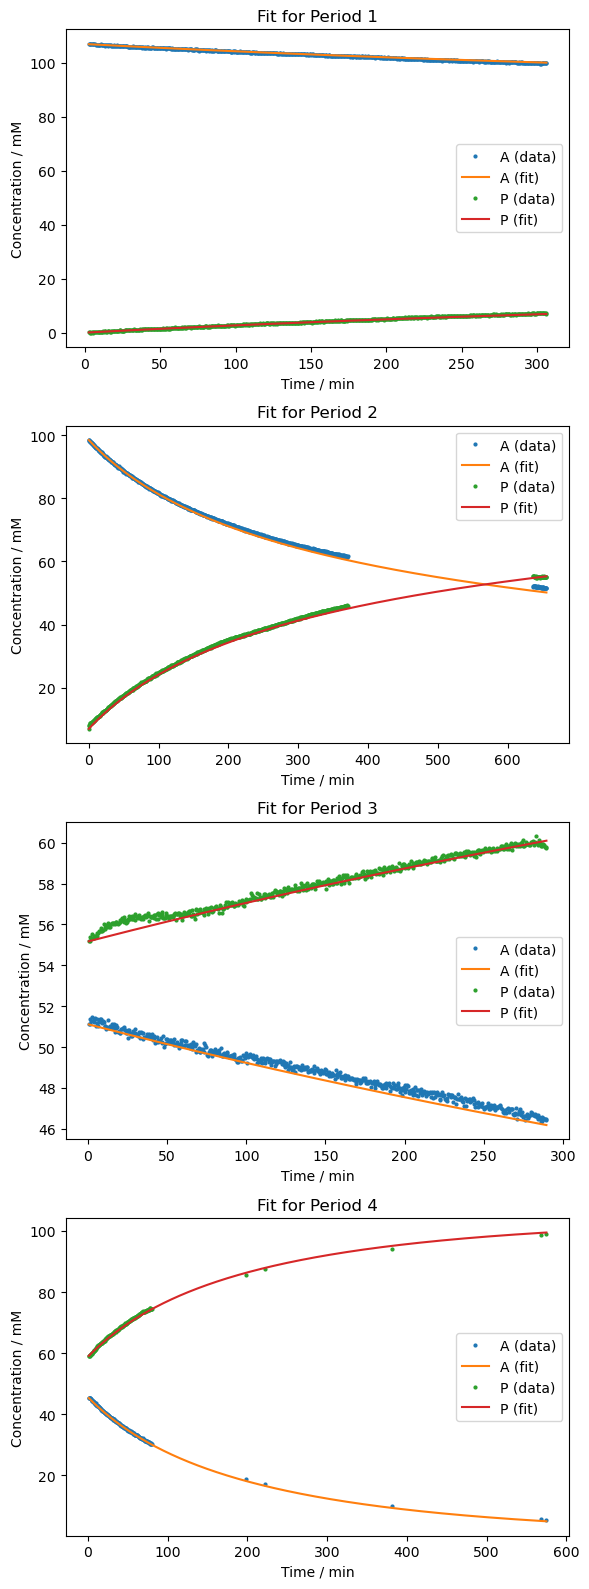

Combined best-fit graph saved as: Results_C4\plots\C4_E6.tiff


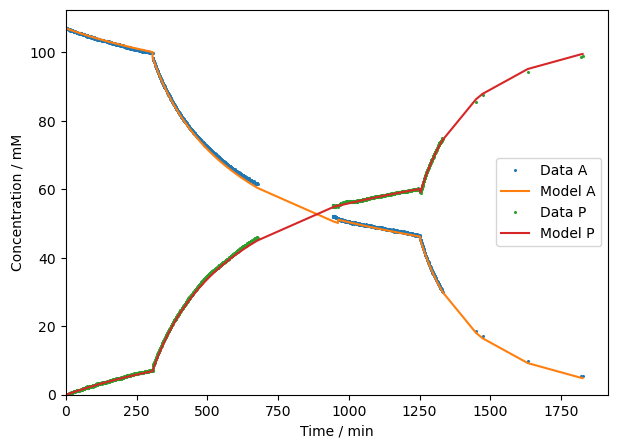

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C4_E6 0.000030641 0.004270955 0.001617424 0.999592888 0.999587668   

       RMSE_A      RMSE_P  RMSE_total  
0 0.481445318 0.479786454 0.480615886

Dataset being analysed: C4_E7.xlsx
Number of datapoints per SAKE period: [1354, 320, 683, 1717]


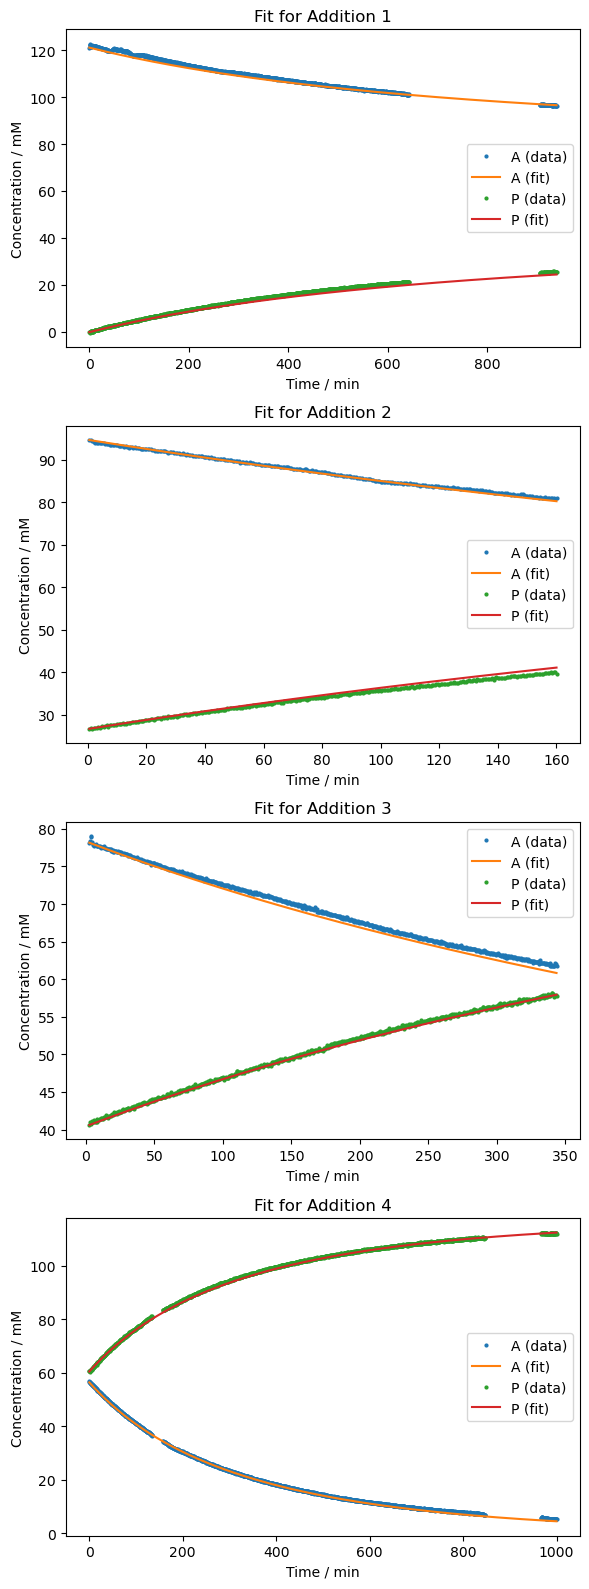

Combined best-fit graph saved as: Results_C4\plots\C4_E7.tiff


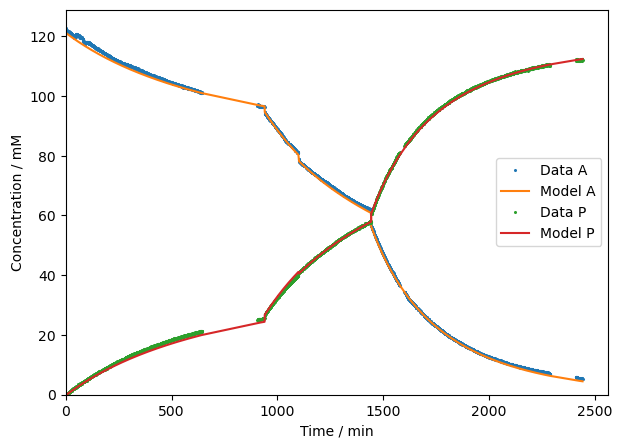

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C4_E7 0.000176464 0.000736091 0.000131775 0.999662050 0.999680125   

       RMSE_A      RMSE_P  RMSE_total  
0 0.740838924 0.682154855 0.711496890

Dataset being analysed: C4_E8.xlsx
Number of datapoints per SAKE period: [1413, 283, 695, 1672]


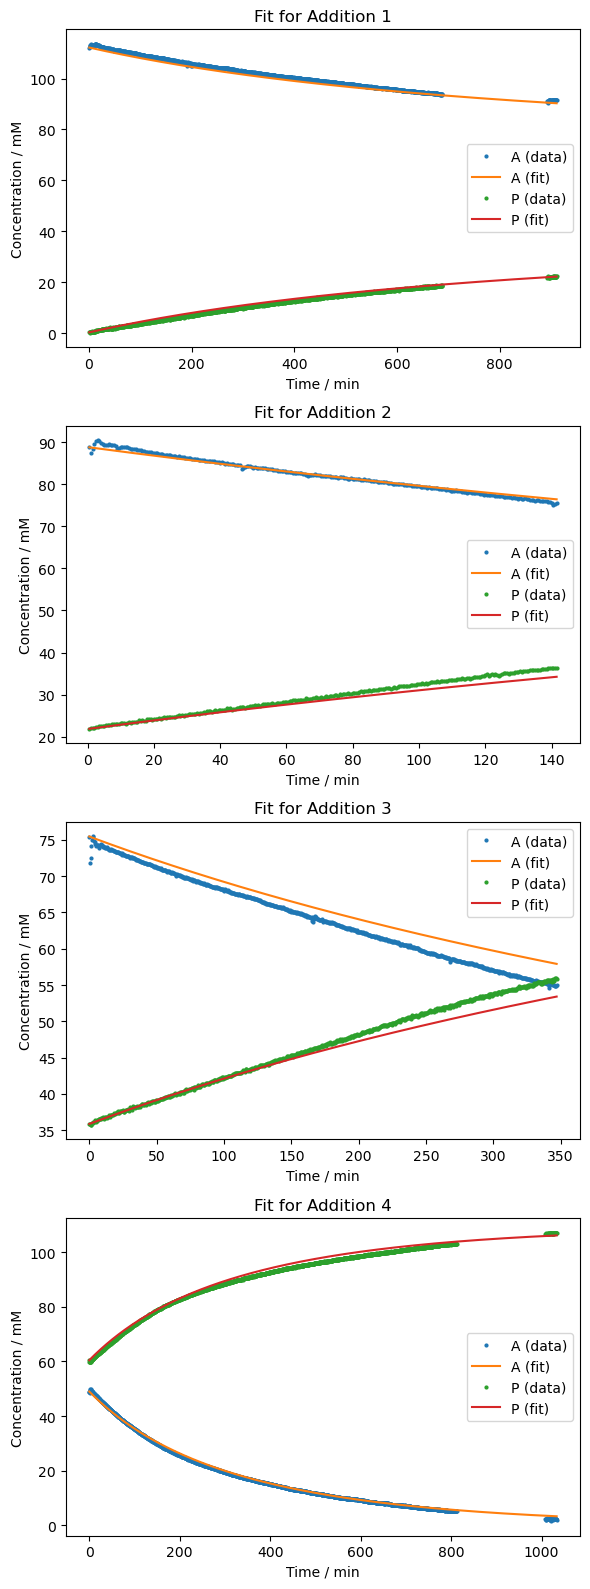

Combined best-fit graph saved as: Results_C4\plots\C4_E8.tiff


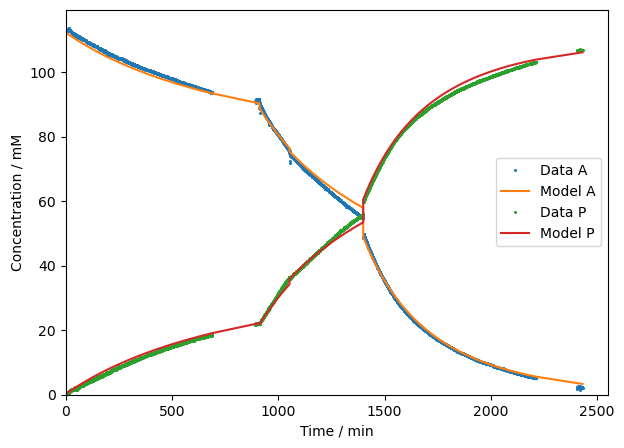

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C4_E8 0.000170497 0.000761148 0.000001000 0.999205900 0.999120065   

       RMSE_A      RMSE_P  RMSE_total  
0 1.074421854 1.069105127 1.071763490

Dataset being analysed: C4_E9.xlsx
Number of datapoints per SAKE period: [2640, 621, 388, 1387]


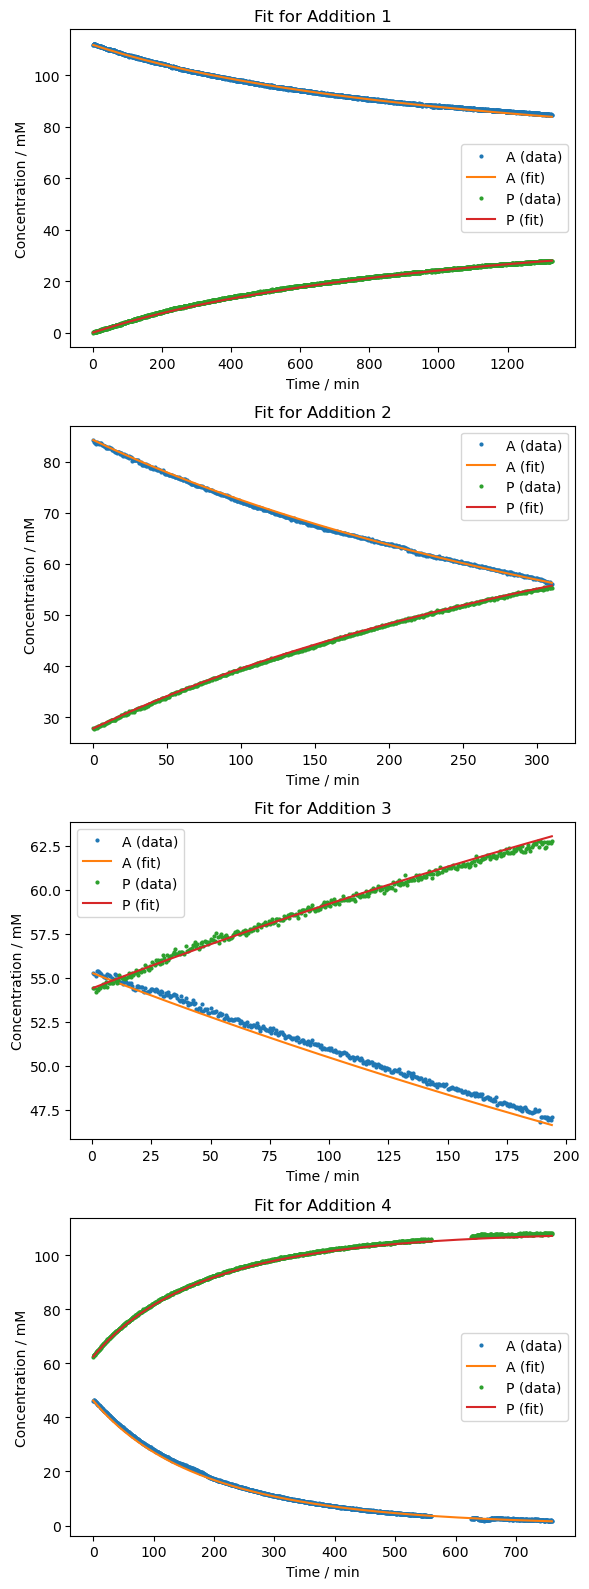

Combined best-fit graph saved as: Results_C4\plots\C4_E9.tiff


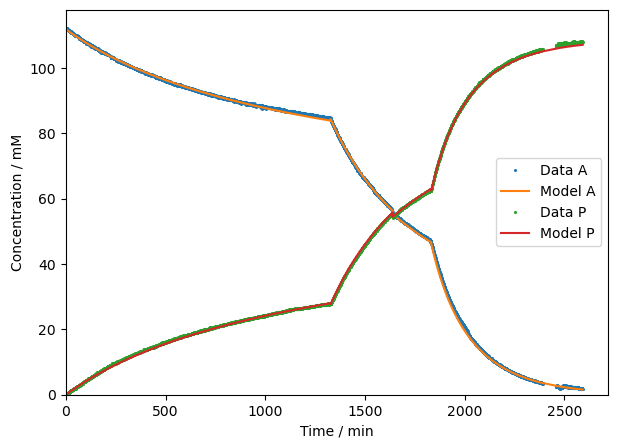

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0   C4_E9 0.000082992 0.001170071 0.000571364 0.999865870 0.999844758   

       RMSE_A      RMSE_P  RMSE_total  
0 0.415447910 0.432602584 0.424025247

Dataset being analysed: C4_E10.xlsx
Number of datapoints per SAKE period: [1129, 593, 1316, 563]


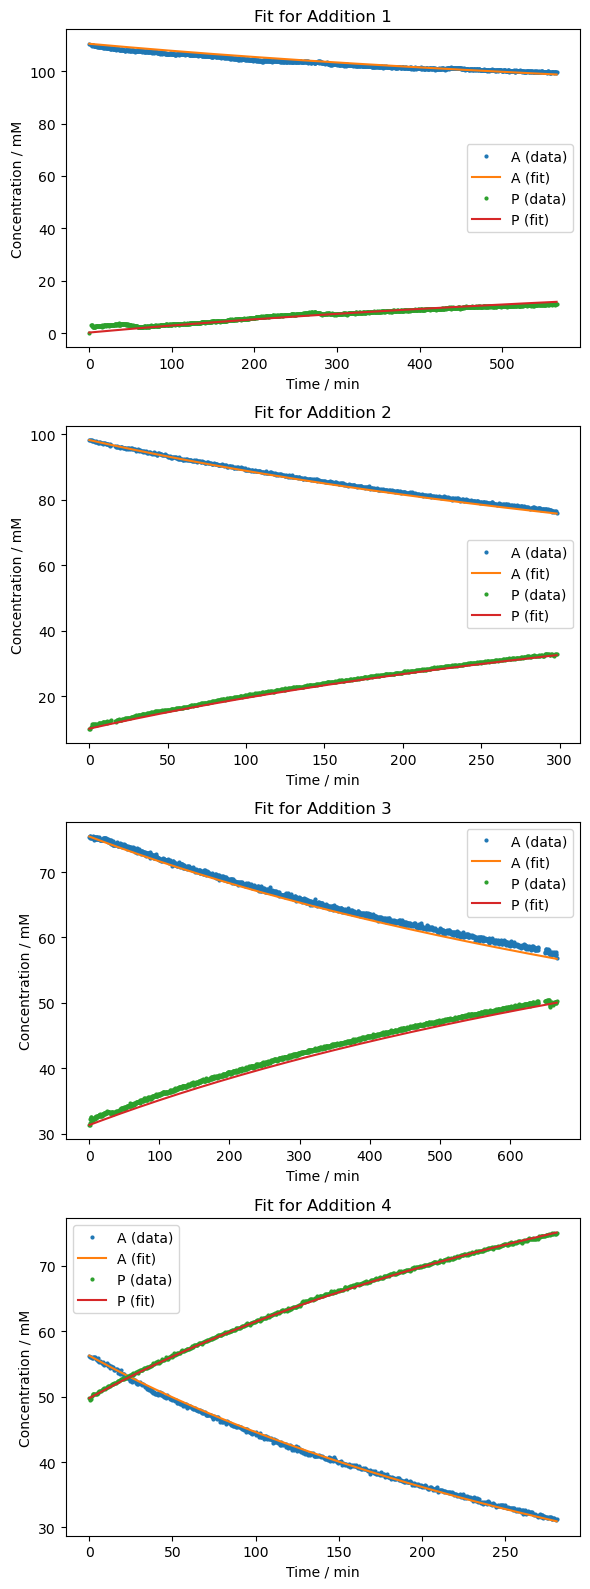

Combined best-fit graph saved as: Results_C4\plots\C4_E10.tiff


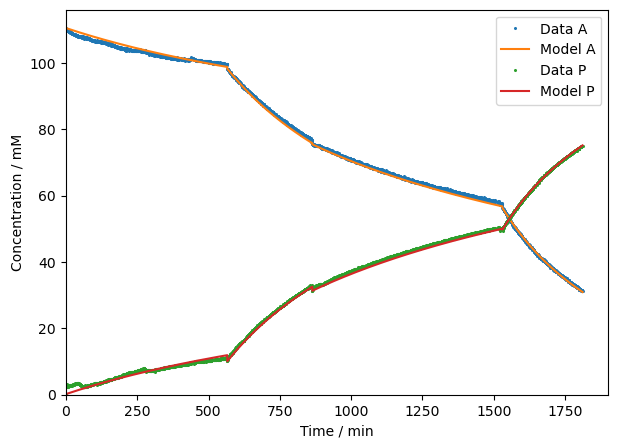

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0  C4_E10 0.000082770 0.001116164 0.001537759 0.999086179 0.998862101   

       RMSE_A      RMSE_P  RMSE_total  
0 0.676595581 0.707817771 0.692206676

Dataset being analysed: C4_E11.xlsx
Number of datapoints per SAKE period: [1430, 911, 2373]


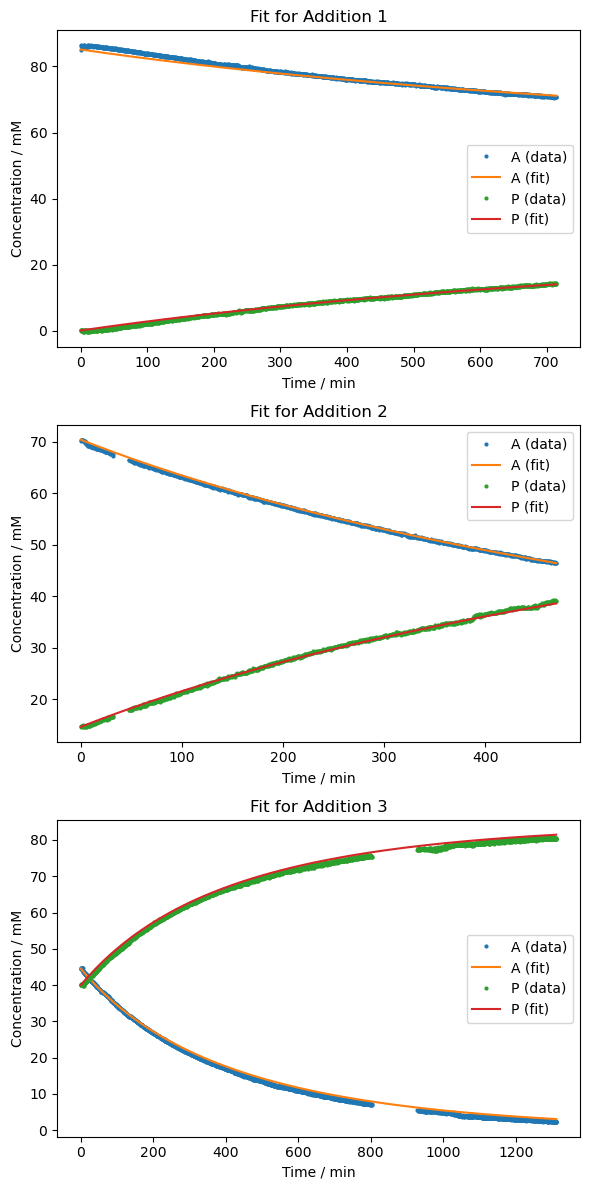

Combined best-fit graph saved as: Results_C4\plots\C4_E11.tiff


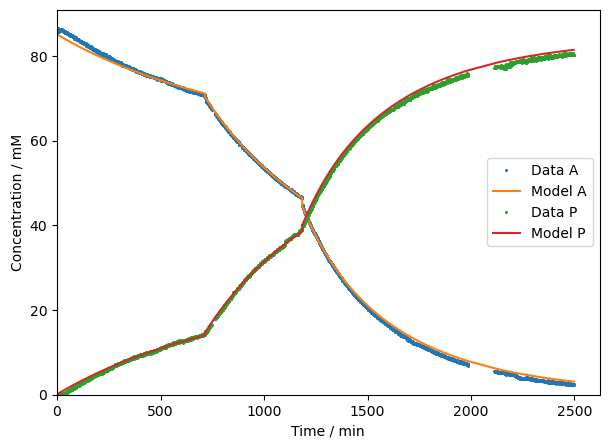

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0  C4_E11 0.000166412 0.000448284 0.001698147 0.999461367 0.999490008   

       RMSE_A      RMSE_P  RMSE_total  
0 0.690770747 0.646190275 0.668480511

In [16]:
results_S3_C4 = []
folder_C4 = "Results_C4"

os.makedirs(folder_C4, exist_ok=True)

for path in Experiment_paths_C4:
    print("\033[1mDataset being analysed:\033[0m", os.path.basename(path))

    df_params = fit_and_analyse_selected_3parameter_model(
        path,
        convert_to_SI=True,
        save_combined_plot=True,
        combined_plot_name=Path(path).stem,
        figure_folder=os.path.join(folder_C4, "plots"),
        KI_speed=0.5
        )

    dataset_name = Path(path).stem
    df_params.insert(0, "Dataset", dataset_name)

    print("Best-fit parameters:")
    display(df_params)

    results_S3_C4.append(df_params)

output_path = os.path.join(folder_C4, "C4_kinetic_modelling_results.xlsx")

# One sheet with all datasets stacked
final_df = pd.concat(results_S3_C4, ignore_index=True)
final_df.to_excel(output_path, index=False)

### Repeated Experiments Combined Datasets

In [17]:
Experiment_names_repeats_combined=['C1_E4a-b','C2_E7a-b','C4_E1a-b']
Experiment_paths_repeats_combined=[path_datasets+i+'.xlsx' for i in Experiment_names_repeats_combined]

Dataset being analysed: C1_E4a-b.xlsx
Number of datapoints per SAKE period: [262, 62, 109, 173, 275, 48, 110, 628]


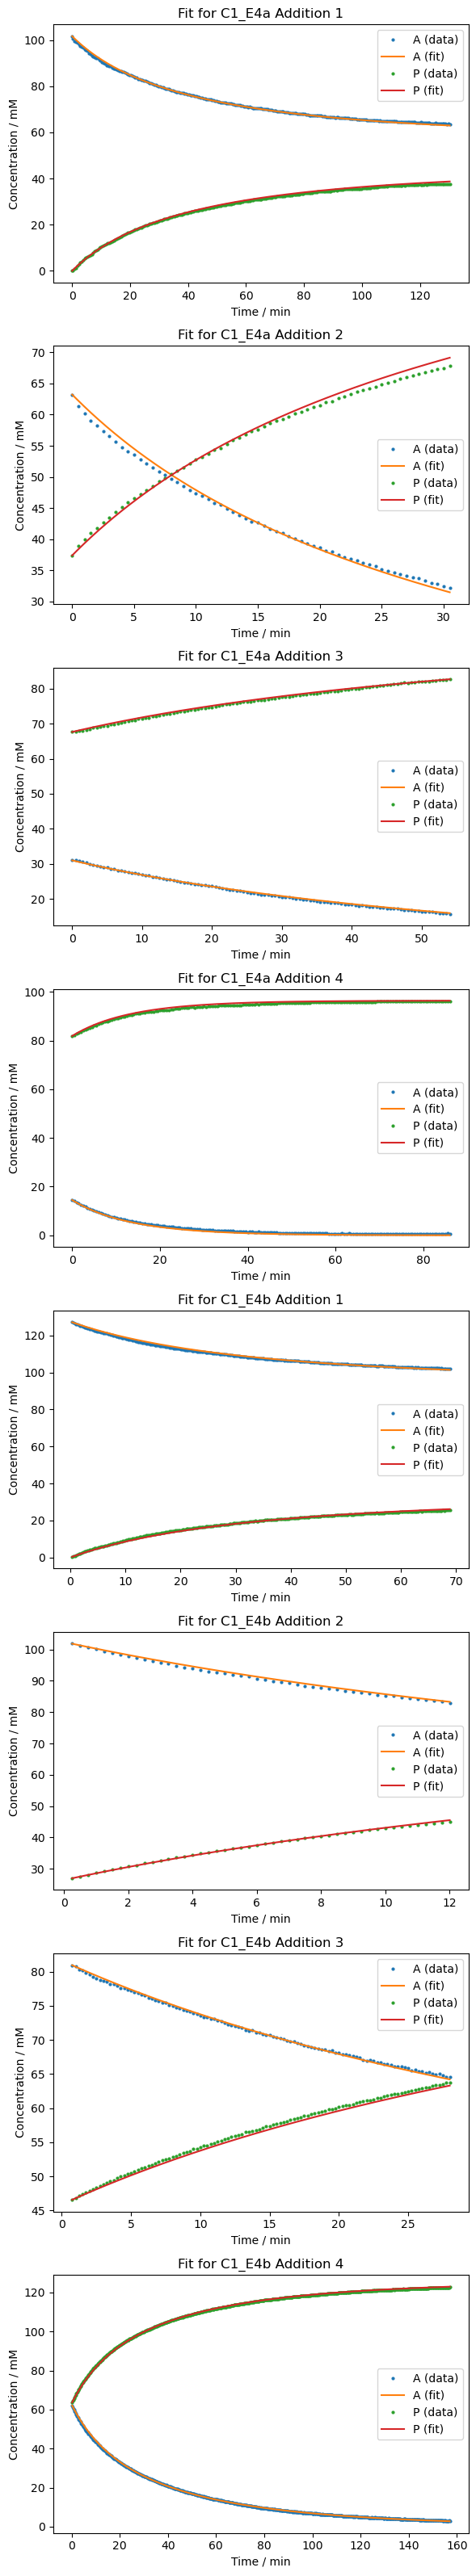

Combined best-fit graph saved as: Results_Combined_datasets\plots\C1_E4a-b.tiff


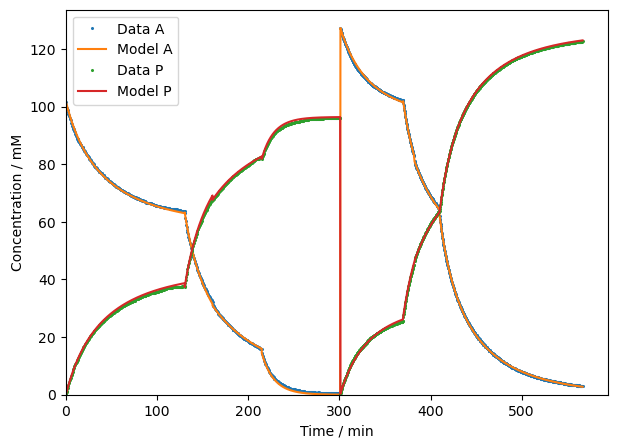

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0  C1_E4a-b 0.003643803 0.025725256 0.000972600 0.999904949 0.999882916   

       RMSE_A      RMSE_P  RMSE_total  
0 0.387179445 0.425852828 0.406516136

Dataset being analysed: C2_E7a-b.xlsx
Number of datapoints per SAKE period: [31, 17, 42, 20, 33, 16, 31, 34]


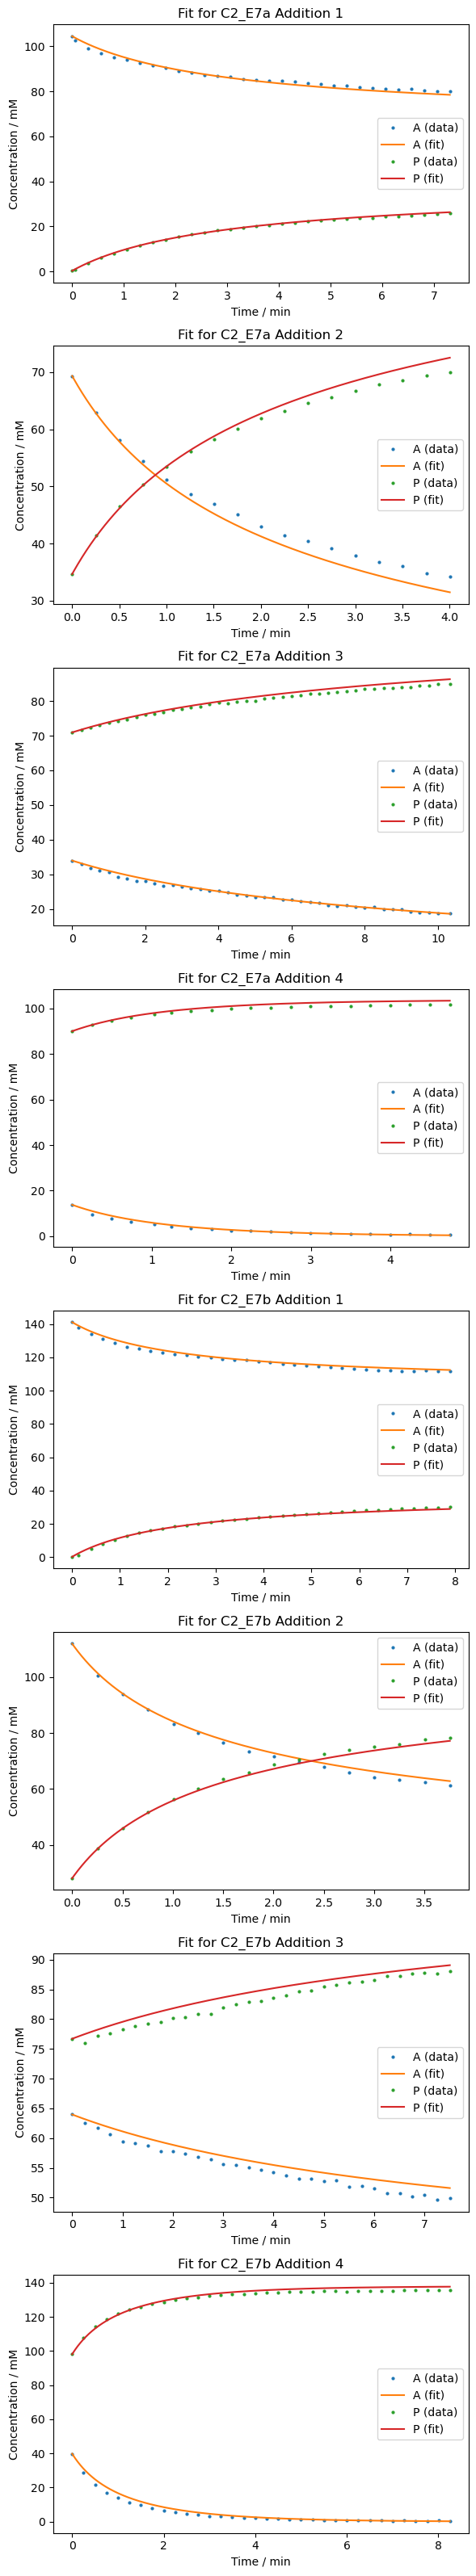

Combined best-fit graph saved as: Results_Combined_datasets\plots\C2_E7a-b.tiff


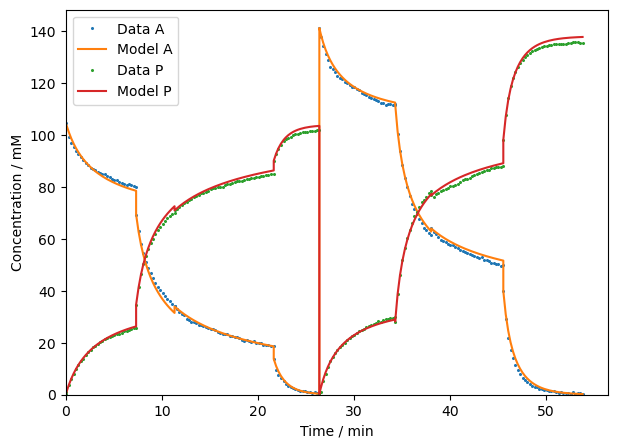

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0  C2_E7a-b 0.018720238 1.203817218 0.000909628 0.999160286 0.999182087   

       RMSE_A      RMSE_P  RMSE_total  
0 1.168780587 1.094644472 1.131712530

Dataset being analysed: C4_E1a-b.xlsx
Number of datapoints per SAKE period: [1122, 614, 2951, 1331, 368, 1215, 1230]


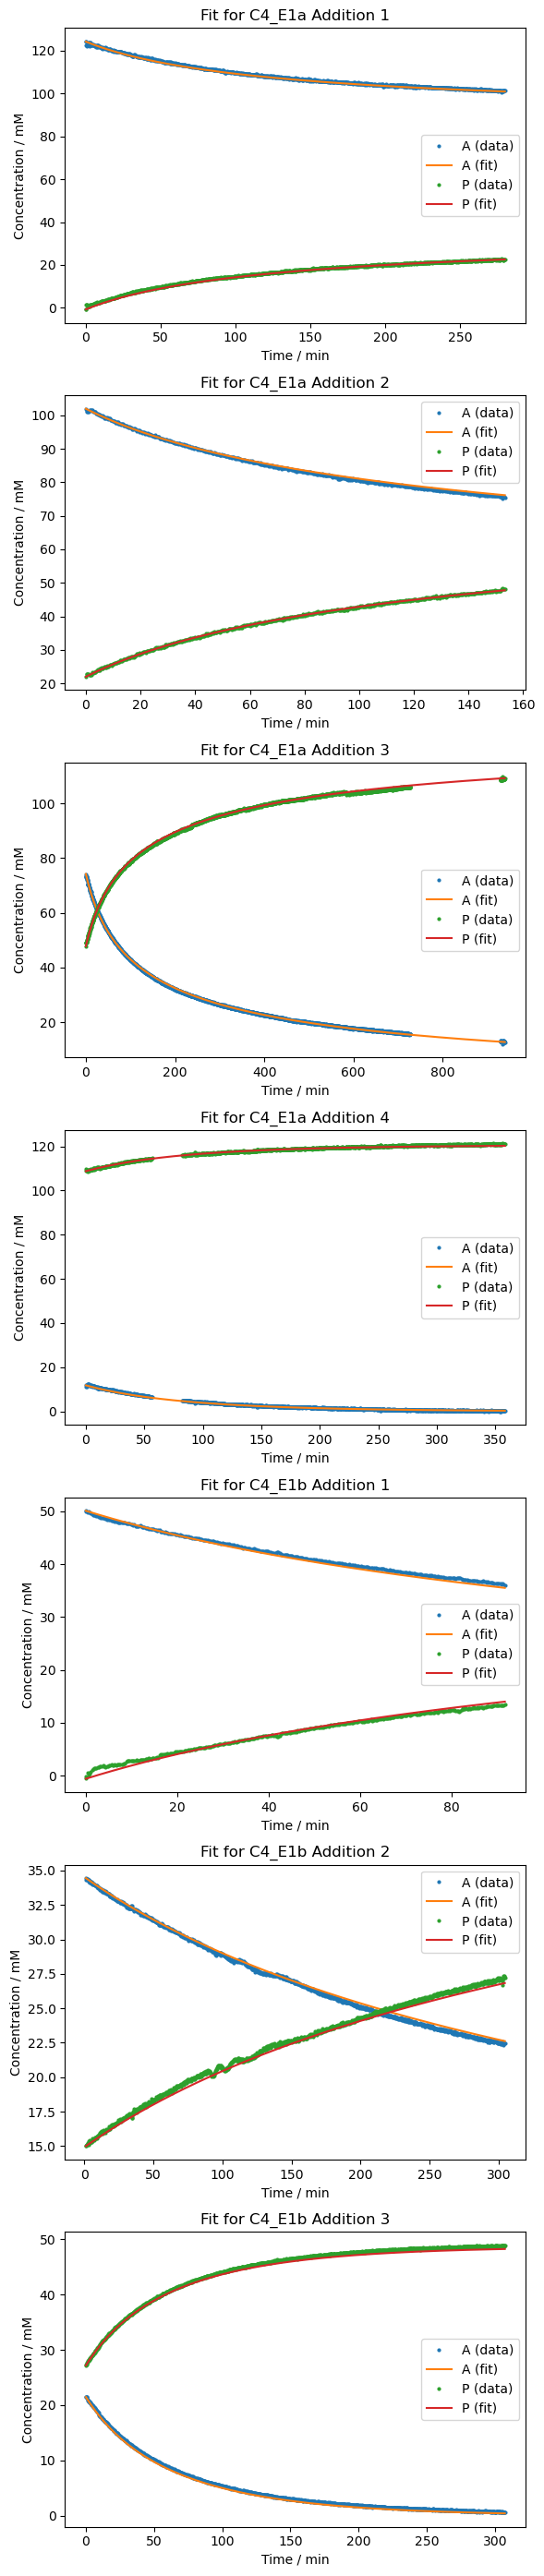

Combined best-fit graph saved as: Results_Combined_datasets\plots\C4_E1a-b.tiff


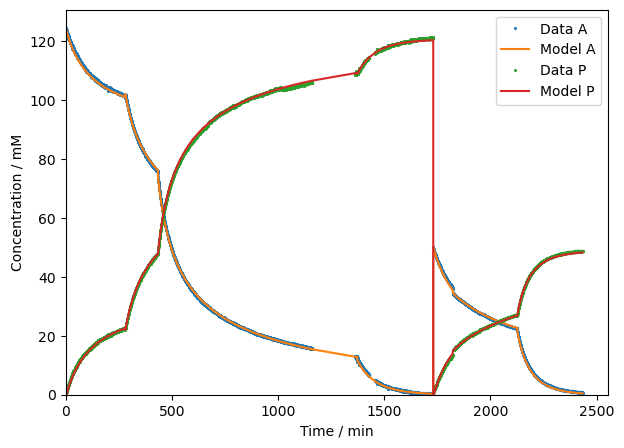

Best-fit parameters:


Dataset         Kk2         Kk3          KI        R2_A        R2_P  \
0  C4_E1a-b 0.000548337 0.024454788 0.005839260 0.999914536 0.999898772   

       RMSE_A      RMSE_P  RMSE_total  
0 0.325548517 0.398574770 0.362061644

In [19]:
results_S3_Combined_datasets = []
folder_Combined_datasets = "Results_Combined_datasets"

os.makedirs(folder_Combined_datasets, exist_ok=True)

for path in Experiment_paths_repeats_combined:
    print("\033[1mDataset being analysed:\033[0m", os.path.basename(path))
    
    df_params = fit_and_analyse_selected_3parameter_model(
        path,
        convert_to_SI=True,
        save_combined_plot=True,
        combined_plot_name=Path(path).stem,
        figure_folder=os.path.join(folder_Combined_datasets, "plots"),
        )

    dataset_name = Path(path).stem
    df_params.insert(0, "Dataset", dataset_name)

    print("Best-fit parameters:")
    display(df_params)

    results_S3_Combined_datasets.append(df_params)

output_path = os.path.join(folder_Combined_datasets, "Combined_datasets_kinetic_modelling_results.xlsx")

# One sheet with all datasets stacked
final_df = pd.concat(results_S3_Combined_datasets, ignore_index=True)
final_df.to_excel(output_path, index=False)
